## Imports

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, InputLayer, BatchNormalization, Dropout, SpatialDropout2D
from tensorflow.keras.layers import Input, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, TruePositives, TrueNegatives, FalsePositives, FalseNegatives, Precision, Recall, AUC 
from tensorflow.keras.callbacks import EarlyStopping,CSVLogger,ModelCheckpoint,ReduceLROnPlateau,Callback
from tensorflow.keras.layers import RandomSaturation, RandomContrast, RandomFlip, RandomRotation
from tensorflow.keras.regularizers import L2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
import tensorflow_datasets as tfds
import cv2
import albumentations as A
import datetime
from sklearn.metrics import confusion_matrix
import io
import os
import shutil
import seaborn as sns
from tensorboard.plugins.hparams import api as hp
import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint, WandbEvalCallback

## Exploring Data Loading

In [2]:
# malaria classification is based on image 
# https://www.tensorflow.org/datasets/catalog/malaria -> more about data
# image dataset is of 3-dimension, (None,None,3)
# 3 here refers to R, G, B values of the pixel
# data is available in tf.data.Dataset format
data = tfds.load('malaria')

2025-07-29 01:25:20.426677: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2025-07-29 01:25:20.426701: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-07-29 01:25:20.426706: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-07-29 01:25:20.426725: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-07-29 01:25:20.426734: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
data

{'train': <_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>}

In [4]:
len(data['train'])

27558

In [5]:
# to shuffle and split a dataset into train cv and test sets, without pre-defined fuctions, i.e with custom functions,

def shuffle_split_dataset(data, train_ratio, cv_ratio):
    size = len(data)
    if size<=1000:
        buffer = size
    elif size<=10000:
        buffer = int(0.75*size)
    elif size<=50000:
        buffer = int(0.5*size)
    elif size<=100000:
        buffer = int(0.35*size)
    else :
        buffer = int(0.25*size)
    
    # buffer size is necessary for applying shuffle 
    shuffled_data = data.shuffle(buffer_size=buffer,seed=42)
    
    return shuffled_data.take(int(train_ratio*size)),shuffled_data.skip(int(train_ratio*size)).take(int(cv_ratio*size)),shuffled_data.skip(int((train_ratio+cv_ratio)*size))


In [6]:
train_set, cv_set, test_set = shuffle_split_dataset(data['train'], 0.8,0.1)

In [7]:
a = test_set.take(3)

In [8]:
b = test_set.take(3)

In [9]:
a == b

False

In [2]:
# to extract label as parasitised or un-infected 
def extract_label(label):
    if label==1:
        return 'Uninfected'
    else:
        return 'Parasitised'

2025-07-29 01:25:21.979229: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


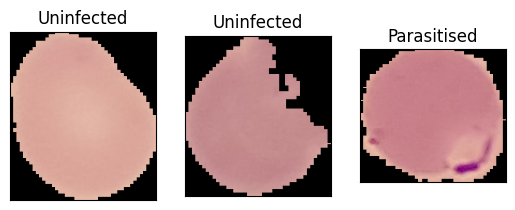

In [11]:
# so lets plot to understand if they are same,
for i,sample in enumerate(a):
    ax = plt.subplot(1,3,i+1)
    plt.imshow(sample['image'])
    plt.title(extract_label(sample['label'].numpy()))
    plt.xticks(ticks=[])
    plt.yticks(ticks=[])

2025-07-29 01:25:23.474972: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


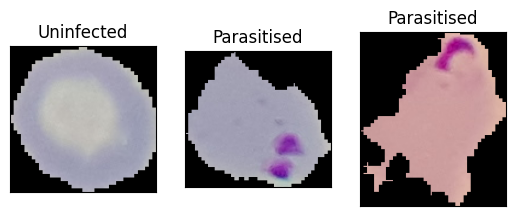

In [12]:
for i,sample in enumerate(b):
    ax = plt.subplot(1,3,i+1)
    plt.imshow(sample['image'])
    plt.title(extract_label(sample['label'].numpy()))
    plt.xticks(ticks=[])
    plt.yticks(ticks=[])

Above custom method always generates a new sequence of random samples from the set whenever it is iterated, .take()/.skip() is called. So better to use the built in method to avoid this randomization every time

In [3]:
# all the data has been under 'train', we can assign to train, cv and test sets according to our needs
data = tfds.load('malaria',split=['train[:80%]','train[80%:90%]','train[90%:]'],shuffle_files=True)

2025-07-29 14:04:14.203592: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2025-07-29 14:04:14.203629: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-07-29 14:04:14.203633: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-07-29 14:04:14.203820: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-07-29 14:04:14.203834: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
len(data)

3

In [5]:
# the data has 3 different sets, accordingly to our split
data

[<_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>,
 <_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>,
 <_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>]

In [6]:
len(data[0])

22046

In [7]:
train_set = data[0]
cv_set = data[1]
test_set = data[2]

In [8]:
a = test_set.take(3)
b = test_set.take(3)

In [9]:
# this always returns False, as they are distinct Python objects in memory, 
# even if they represent the same logical operation on the same underlying dataset. 
# Python's == operator for objects often checks for identity (are they the exact same object in memory?), 
# not content equality for complex structures like datasets.
a == b

False

2025-07-29 14:04:14.371622: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


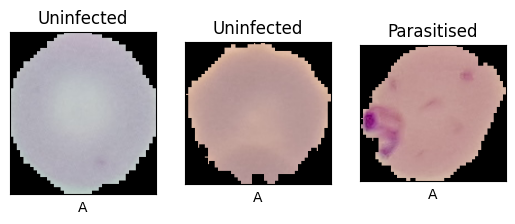

In [10]:
for i,sample in enumerate(a):
    ax = plt.subplot(1,3,i+1)
    plt.imshow(sample['image'])
    plt.title(extract_label(sample['label'].numpy()))
    plt.xlabel('A')
    plt.xticks(ticks=[])
    plt.yticks(ticks=[])

2025-07-29 14:04:14.445653: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


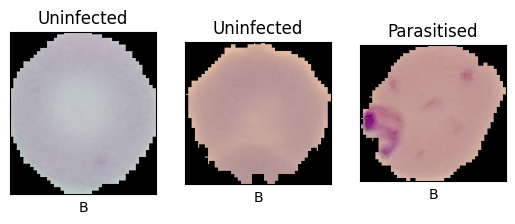

In [11]:
for i,sample in enumerate(b):
    ax = plt.subplot(1,3,i+1)
    plt.imshow(sample['image'])
    plt.title(extract_label(sample['label'].numpy()))
    plt.xlabel('B')
    plt.xticks(ticks=[])
    plt.yticks(ticks=[])

In [12]:
del a,b

So, the elements retrieved are same evrytime when the set is accessed.
Make use of built in methods, rather than custom ones

## Exploring data 

In [13]:
len(train_set)

22046

In [14]:
len(cv_set)

2756

In [15]:
len(test_set)

2756

In [16]:
len(train_set)+len(cv_set)+len(test_set)

27558

In [17]:
for sample in train_set.take(1):
    print(sample)

{'image': <tf.Tensor: shape=(151, 115, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, 'label': <tf.Tensor: shape=(), dtype=int64, numpy=1>}


2025-07-29 14:04:14.511224: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [18]:
for sample in train_set.take(3):
    print(sample['label'])

tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)


2025-07-29 14:04:14.530770: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2025-07-29 14:04:14.649070: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


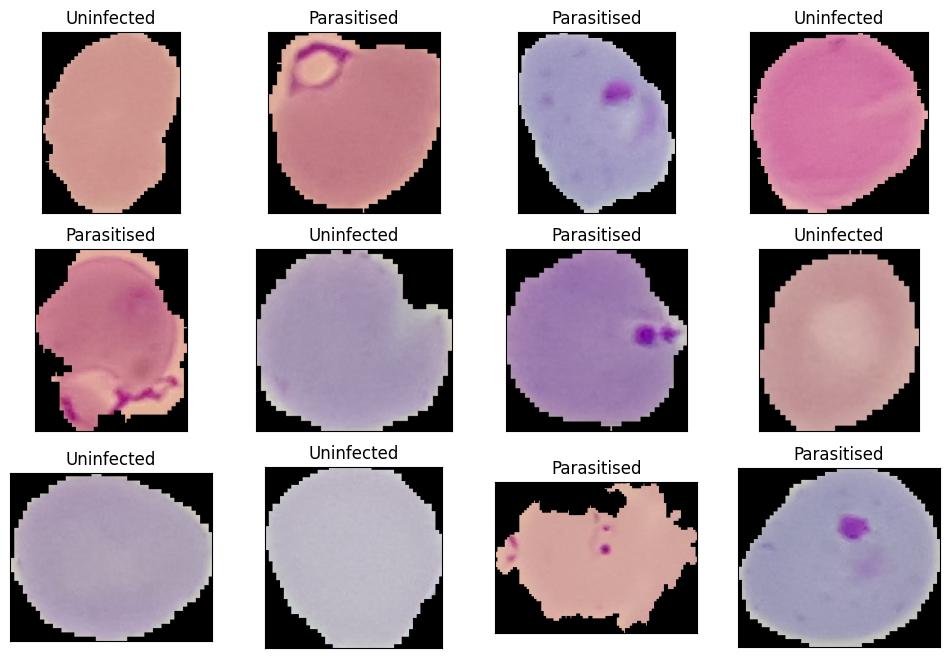

In [19]:
plt.figure(figsize=(12,8))
for i,sample in enumerate(train_set.take(12)):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(sample['image'])
    plt.title(extract_label(sample['label'].numpy()))
    plt.xticks(ticks=[])
    plt.yticks(ticks=[])

In [20]:
# as we can see, images have different size, 
# we need a uniform image size across the dataset in order to input into the model
# along with resizing, we also can normalize the image
# as the pixel values range from 0(x_min)-255(x_max), (x-x_min)/(x_max-x_min) => x-0/255-0 => x/255
# divide the whole resize image by 255 to normalize the data,
# if we dont normalize, we cant plot the data back

def image_resize(data):
    return tf.image.resize(data['image'],size=(224,224))/255 , data['label']

In [21]:
for image in train_set.take(2):
    print(image['image'].shape)
    print(image_resize(image)[0].shape,'\n')

(103, 103, 3)
(224, 224, 3) 

(106, 121, 3)
(224, 224, 3) 



2025-07-29 14:04:14.865502: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [22]:
train_set = train_set.map(image_resize)

In [23]:
for x,y in train_set.take(1):
    print(x)
    print(y)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32)
tf.Tensor(1, shape=(), dtype=int64)


2025-07-29 14:04:14.904973: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2025-07-29 14:04:14.960045: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


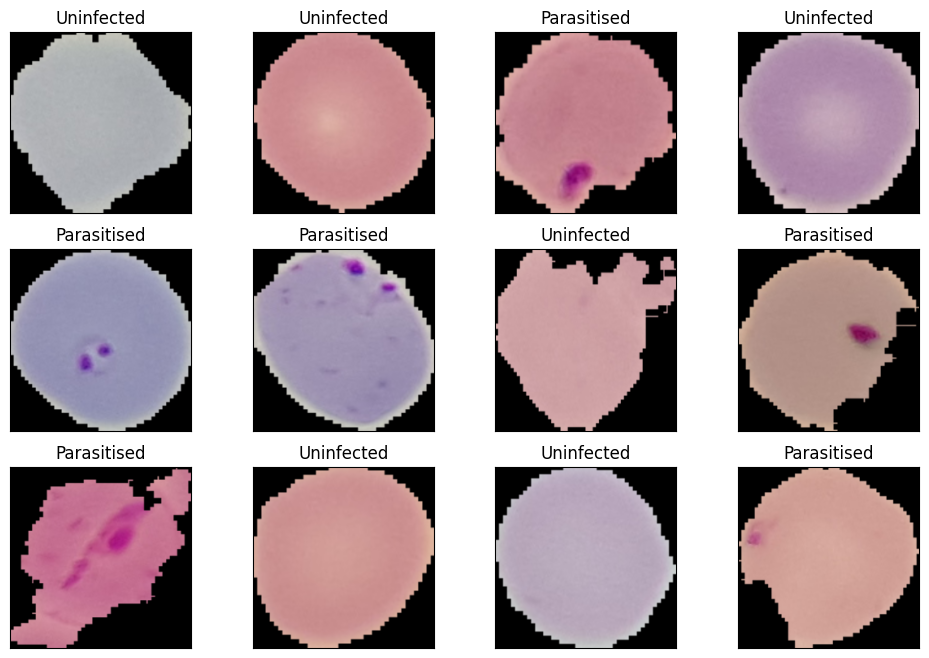

In [24]:
plt.figure(figsize=(12,8))
for i,sample in enumerate(train_set.take(12)):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(sample[0])
    plt.title(extract_label(sample[1].numpy()))
    plt.xticks(ticks=[])
    plt.yticks(ticks=[])

In [25]:
train_set = train_set.shuffle(buffer_size=int(0.75*len(train_set)),reshuffle_each_iteration=True).batch(batch_size=64).cache().prefetch(tf.data.AUTOTUNE)


## Common Data Loading

In [2]:
data = tfds.load('malaria',split=['train[:80%]','train[80%:85%]','train[85%:]'],shuffle_files=True)
train_set = data[0]
cv_set = data[1]
test_set = data[2]

def image_resize(data):
    return tf.image.resize(data['image'],size=(224,224))/255 , data['label']

2025-09-25 21:15:23.279844: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2025-09-25 21:15:23.279879: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-09-25 21:15:23.279882: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2025-09-25 21:15:23.279898: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-09-25 21:15:23.279912: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
train_set = train_set.map(image_resize)
train_set = train_set.batch(batch_size=64).cache().prefetch(tf.data.AUTOTUNE)

In [3]:
cv_set = cv_set.map(image_resize)
cv_set = cv_set.batch(batch_size=64).cache().prefetch(tf.data.AUTOTUNE)

In [4]:
test_set = test_set.map(image_resize)
test_set = test_set.batch(batch_size=64).cache().prefetch(tf.data.AUTOTUNE)

## Model 1 : Sequential API

In [26]:
# building the model now,

from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, InputLayer, BatchNormalization

model = tf.keras.Sequential([
    InputLayer(input_shape=(224,224,3)),
    Conv2D(filters=6, kernel_size=(3,3), strides=(1,1), padding='valid',activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2), strides=(2,2)),
    
    Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid',activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    
    Flatten(),
    
    Dense(units=100,activation='relu'),
    BatchNormalization(),
    Dense(units=50,activation='relu'),
    BatchNormalization(),
    Dense(units=1,activation='sigmoid')   
])

model.summary()

/opt/anaconda3/envs/tf_env/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 16)   │           880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 46656)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │     4,665,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 50)             │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,672,537 (17.82 MB)

 Trainable params: 4,672,193 (17.82 MB)

 Non-trainable params: 344 (1.34 KB)

In [27]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy

model.compile(optimizer=Adam(learning_rate=0.01),
             loss=BinaryCrossentropy(),
             metrics=[BinaryAccuracy()])

In [28]:
history = model.fit(train_set,epochs=8)

Epoch 1/8


2025-07-29 14:04:15.646032: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


345/345 ━━━━━━━━━━━━━━━━━━━━ 30s 75ms/step - binary_accuracy: 0.6410 - loss: 0.6533
Epoch 2/8
345/345 ━━━━━━━━━━━━━━━━━━━━ 67s 195ms/step - binary_accuracy: 0.7638 - loss: 0.5971
Epoch 3/8
345/345 ━━━━━━━━━━━━━━━━━━━━ 66s 191ms/step - binary_accuracy: 0.7650 - loss: 0.6070
Epoch 4/8
345/345 ━━━━━━━━━━━━━━━━━━━━ 66s 190ms/step - binary_accuracy: 0.7720 - loss: 0.5889
Epoch 5/8
345/345 ━━━━━━━━━━━━━━━━━━━━ 65s 189ms/step - binary_accuracy: 0.8390 - loss: 0.4843
Epoch 6/8
345/345 ━━━━━━━━━━━━━━━━━━━━ 60s 173ms/step - binary_accuracy: 0.8872 - loss: 0.3567
Epoch 7/8
345/345 ━━━━━━━━━━━━━━━━━━━━ 55s 158ms/step - binary_accuracy: 0.9057 - loss: 0.3023
Epoch 8/8
345/345 ━━━━━━━━━━━━━━━━━━━━ 56s 162ms/step - binary_accuracy: 0.9135 - loss: 0.2738


In [30]:
model.evaluate(cv_set)

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - binary_accuracy: 0.9229 - loss: 0.3025


[0.3084546625614166, 0.9208998680114746]

In [32]:
# to extract label as parasitised or un-infected 
def extract_label(label):
    if label==1:
        return 'U'
    else:
        return 'P'

2025-07-29 14:12:00.876684: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


2025-07-29 14:12:02.047055: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


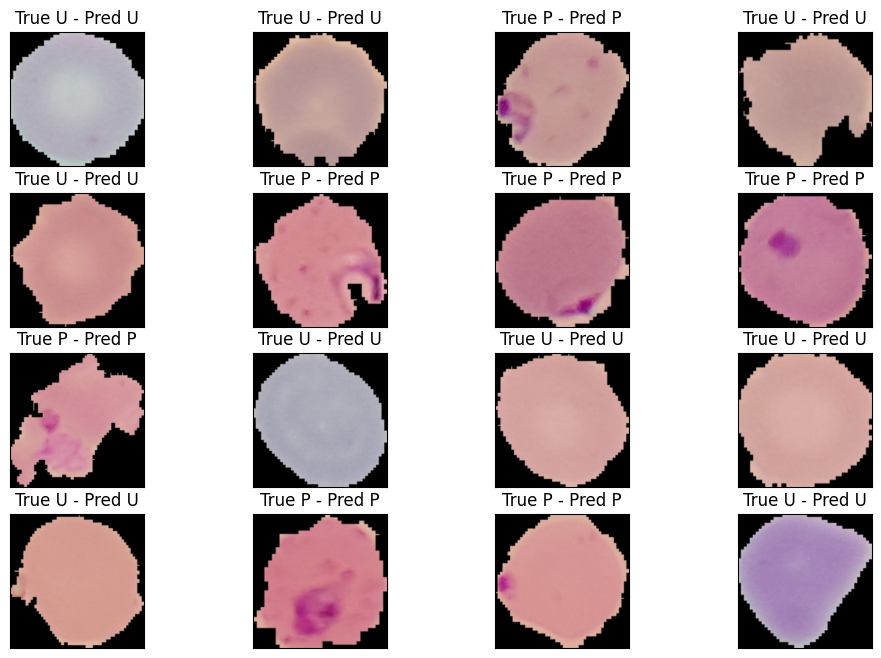

In [33]:
for image, label in test_set.take(1):
    plt.figure(figsize=(12,8))
    for i in range(16):
        ax = plt.subplot(4,4,i+1)
        plt.imshow(image[i])
        plt.title("True "+extract_label(label[i].numpy())+" - Pred "+extract_label(tf.round(model.predict(image)[i])))
        plt.xticks(ticks=[])
        plt.yticks(ticks=[])


___

## Functional API

3 ways of building the model :
* Sequential
* Functional
* Subclassing

These methods have their own advantage like simplicity, flexibility,.. suited for different use case complexities

In Functional API, we pass in the output of a layer to its next layer

In [5]:
input_image = Input(shape=(224,224,3))

layer_output = Conv2D(filters=6, kernel_size=(3,3), strides=(1,1), padding='valid',activation='relu')(input_image)
layer_output = BatchNormalization()(layer_output)
layer_output = MaxPool2D(pool_size=(2,2), strides=(2,2))(layer_output)

layer_output = Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid',activation='relu')(layer_output)
layer_output = BatchNormalization()(layer_output)
layer_output = MaxPool2D(pool_size=(2,2),strides=(2,2))(layer_output)

layer_output = Flatten()(layer_output)

layer_output = Dense(units=100,activation='relu')(layer_output)
layer_output = BatchNormalization()(layer_output)
layer_output = Dense(units=50,activation='relu')(layer_output)
layer_output = BatchNormalization()(layer_output)

#final output
final_output = Dense(units=1,activation='sigmoid')(layer_output)   

model = Model(input_image, final_output)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 16)   │           880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 46656)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │     4,665,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 50)             │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,672,537 (17.82 MB)

 Trainable params: 4,672,193 (17.82 MB)

 Non-trainable params: 344 (1.34 KB)

In [6]:
model.compile(loss=BinaryCrossentropy(), optimizer=Adam(0.01))

In [7]:
model.fit(cv_set, epochs=3) 

Epoch 1/3


2025-09-25 19:58:33.878792: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - loss: 0.7298
Epoch 2/3
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.6114
Epoch 3/3
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.5322


We can also break down the model into parts and make it work as a function

In [10]:
input_image = Input(shape=(224,224,3))

layer_output = Conv2D(filters=6, kernel_size=(3,3), strides=(1,1), padding='valid',activation='relu')(input_image)
layer_output = BatchNormalization()(layer_output)
layer_output = MaxPool2D(pool_size=(2,2), strides=(2,2))(layer_output)

layer_output = Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid',activation='relu')(layer_output)
layer_output = BatchNormalization()(layer_output)
features = MaxPool2D(pool_size=(2,2),strides=(2,2))(layer_output)


feature_extractor = Model(input_image, features)

feature_extractor.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 222, 222, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 109, 109, 16)   │           880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 109, 109, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 54, 54, 16)     │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,136 (4.44 KB)

 Trainable params: 1,092 (4.27 KB)

 Non-trainable params: 44 (176.00 B)

In [11]:
# using model as a function
extracted_features = feature_extractor(input_image)

layer_output = Flatten()(extracted_features)

layer_output = Dense(units=100,activation='relu')(layer_output)
layer_output = BatchNormalization()(layer_output)
layer_output = Dense(units=50,activation='relu')(layer_output)
layer_output = BatchNormalization()(layer_output)

final_output = Dense(units=1,activation='sigmoid')(layer_output) 

classifier = Model(input_image, final_output)

classifier.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_3 (Functional)       │ (None, 54, 54, 16)     │         1,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 46656)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 100)            │     4,665,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 50)             │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,672,537 (17.82 MB)

 Trainable params: 4,672,193 (17.82 MB)

 Non-trainable params: 344 (1.34 KB)

In [13]:
classifier.compile(loss=BinaryCrossentropy(), optimizer=Adam(0.01))

In [14]:
classifier.fit(cv_set, epochs=3)

Epoch 1/3
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 0.7230 
Epoch 2/3
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.5722
Epoch 3/3
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.4763


## Model Sub Classing

Here, we break down the model into class of custom layer and model, which inherits from tf.keras.layers.Layer and tf.keras.models.Model

In [5]:
class FeatureExtractor(Layer):
    def __init__(self, filters, kernel, strides, pool, padding, activation):
        super().__init__()
        self.conv2d_1 = Conv2D(filters=filters[0], kernel_size=kernel, strides=strides, padding=padding, activation=activation)
        self.batch_1 = BatchNormalization()
        self.maxpool_1 = MaxPool2D(pool_size=pool, strides=strides*2)
        self.conv2d_2 = Conv2D(filters=filters[1], kernel_size=kernel, strides=strides, padding=padding, activation=activation)
        # Each layer instance is designed to handle a specific input shape. So it cant be reused.
        self.batch_2 = BatchNormalization()
        self.maxpool_2 = MaxPool2D(pool_size=pool, strides=strides*2)

    def call(self, x, training=False):
        x = self.conv2d_1(x)
        x = self.batch_1(x)
        x = self.maxpool_1(x)
        x = self.conv2d_2(x)
        x = self.batch_2(x)
        x = self.maxpool_2(x)

        return x

In [6]:
feature_extractor_class = FeatureExtractor(filters=[6,16],kernel=3,strides=1,pool=2,padding='valid',activation='relu')

In [7]:
input_image = Input(shape=(224,224,3))

extracted_features = feature_extractor_class(input_image, training=True)

layer_output = Flatten()(extracted_features)

layer_output = Dense(units=100,activation='relu')(layer_output)
layer_output = BatchNormalization()(layer_output)
layer_output = Dense(units=50,activation='relu')(layer_output)
layer_output = BatchNormalization()(layer_output)

final_output = Dense(units=1,activation='sigmoid')(layer_output) 

malaria_classifier = Model(input_image, final_output)

malaria_classifier.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ feature_extractor               │ (None, 54, 54, 16)     │         1,136 │
│ (FeatureExtractor)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 46656)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │     4,665,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 50)             │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,672,537 (17.82 MB)

 Trainable params: 4,672,193 (17.82 MB)

 Non-trainable params: 344 (1.34 KB)

In [8]:
class MalariaDetector(Model):
    def __init__(self,):
        super().__init__()
        self.featues = FeatureExtractor(filters=[6,16],kernel=3,strides=1,pool=2,padding='valid',activation='relu')
        self.flatten = Flatten()
        self.dense_1 = Dense(units=100,activation='relu')
        self.batch_1 = BatchNormalization()
        self.dense_2 = Dense(units=50,activation='relu')
        self.batch_2 = BatchNormalization()
        self.dense_3 = Dense(units=1,activation='sigmoid')

    def call(self, x, training=False):
        x = self.featues(x)
        x = self.flatten(x)
        x = self.dense_1(x)
        x = self.batch_1(x)
        x = self.dense_2(x)
        x = self.batch_2(x)
        x = self.dense_3(x)

        return x

In [9]:
lenet_malaria = MalariaDetector()
lenet_malaria(tf.zeros(shape=[1,224,224,3]), training=False)
lenet_malaria.summary()

Model: "malaria_detector"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ feature_extractor_1             │ ?                      │         1,136 │
│ (FeatureExtractor)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (1, 46656)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (1, 100)               │     4,665,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (1, 100)               │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (1, 50)                │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (1, 50)                │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (1, 1)                 │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,672,537 (17.82 MB)

 Trainable params: 4,672,193 (17.82 MB)

 Non-trainable params: 344 (1.34 KB)

In [11]:
lenet_malaria.compile(loss=BinaryCrossentropy(), optimizer=tf.keras.optimizers.SGD())

In [12]:
lenet_malaria.fit(cv_set, epochs=3)

Epoch 1/3


2025-09-25 21:17:28.046751: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.7599  
Epoch 2/3
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.5669
Epoch 3/3
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.4856


## Saving Weights along with and without Model

In [36]:
import os

In [37]:
os.makedirs('SavedModels')

In [39]:
model.save(os.path.join('SavedModels','Malaria_Detection_V1.0.keras'))

In [40]:
os.makedirs('SavedWeights')

In [42]:
model.save_weights (os.path.join('SavedWeights','Malaria_Detection_V1.0.weights.h5'))

___

## Loading Saved Model

With saved model (configuration + weights), we can directly load the saved model and use it for prediction 

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [6]:
model = tf.keras.models.load_model(filepath='SavedModels/Malaria_Detection_V1.0.keras')

/opt/anaconda3/envs/tf_env/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 20 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [12]:
model.evaluate(test_set)

130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - binary_accuracy: 0.9181 - loss: 0.3106


[0.30914023518562317, 0.9194484949111938]

___

## Adding metrics to track model performance and loading Saved Weights

In [6]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, TruePositives, TrueNegatives, FalsePositives, FalseNegatives, Precision, Recall, AUC # area under (roc) curve
import numpy as np


In [7]:
metrics = [TruePositives(name='tp'), TrueNegatives(name='tn'), FalsePositives(name='fp'), FalseNegatives(name='fn'),
          BinaryAccuracy(name='BinAcc'), Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]


With just the saved weights, we need to defing the model, with same architecture as the weights need to match, and then load the saved weights into them

In [8]:
# compiling after defining Model 1
model.compile(optimizer=Adam(learning_rate=0.01),
             loss=BinaryCrossentropy(),
             metrics=metrics)

In [9]:
# running the model with the randomly initialised weights
model.evaluate(test_set)

2025-08-10 23:17:18.248048: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - BinAcc: 0.4740 - auc: 0.4669 - fn: 444.4243 - fp: 682.9091 - loss: 0.6967 - precision: 0.4627 - recall: 0.5760 - tn: 411.4091 - tp: 603.5000


[0.696830689907074,
 1184.0,
 783.0,
 1303.0,
 864.0,
 0.47581034898757935,
 0.47607558965682983,
 0.578125,
 0.46188971400260925]

In [10]:
model.save_weights('SavedWeights/Malaria_Randomly_Initialized.weights.h5')

In [11]:
model.load_weights('SavedWeights/Malaria_Detection_V1.0.weights.h5')

/opt/anaconda3/envs/tf_env/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [12]:
# running the model with trained weights
model.evaluate(test_set)

65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - BinAcc: 0.9181 - auc: 0.9487 - fn: 83.0152 - fp: 86.7424 - loss: 0.3113 - precision: 0.9116 - recall: 0.9180 - tn: 1007.5757 - tp: 964.9091


[0.30914026498794556,
 1874.0,
 1927.0,
 159.0,
 174.0,
 0.9194484949111938,
 0.9217904806137085,
 0.9150390625,
 0.9532169103622437]

In [13]:
actual_y = tf.ragged.constant([y.numpy() for x,y in test_set])
actual_y = actual_y.flat_values
actual_y.shape

2025-08-10 23:17:21.583193: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


TensorShape([4134])

In [14]:
pred_y = model.predict(test_set)
pred_y.shape

65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


(4134, 1)

In [15]:
pred_y = pred_y.squeeze()
pred_y.shape

(4134,)

In [16]:
# for plotting confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [17]:
conf_mtrx = confusion_matrix(y_true=actual_y, y_pred=(pred_y>0.5)) # threshold = 0.5
print(conf_mtrx)
# standard output will be in the form
#          | Pred 0 | Pred 1
# ----------------------------
# Actual 0 |  TN    |  FP
# ----------------------------
# Actual 1 |  FN    |  TP

# here, 0 -> infected and 1 -> uninfected
# so we need to reduce FP as an infected case may go untreated as it is predicted as uninfected

[[1927  159]
 [ 174 1874]]


In [18]:
# altering threshold
conf_mtrx = confusion_matrix(y_true=actual_y, y_pred=(pred_y>0.60)) # threshold = 0.6
print(conf_mtrx)

[[1968  118]
 [ 405 1643]]


Text(0.5, 14.722222222222216, 'Predicted')

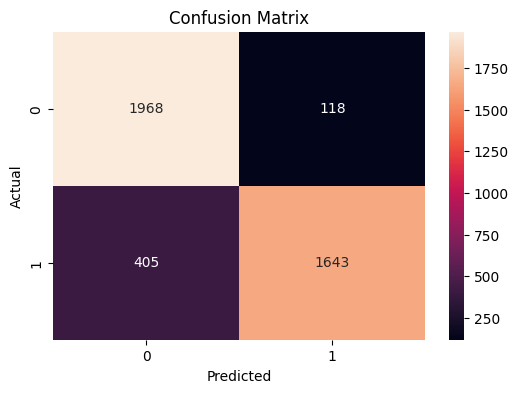

In [19]:
plt.figure(figsize=(6,4))
sns.heatmap(conf_mtrx,annot=True,fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [20]:
# plotting ROC curve
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_true=actual_y, y_score=pred_y)

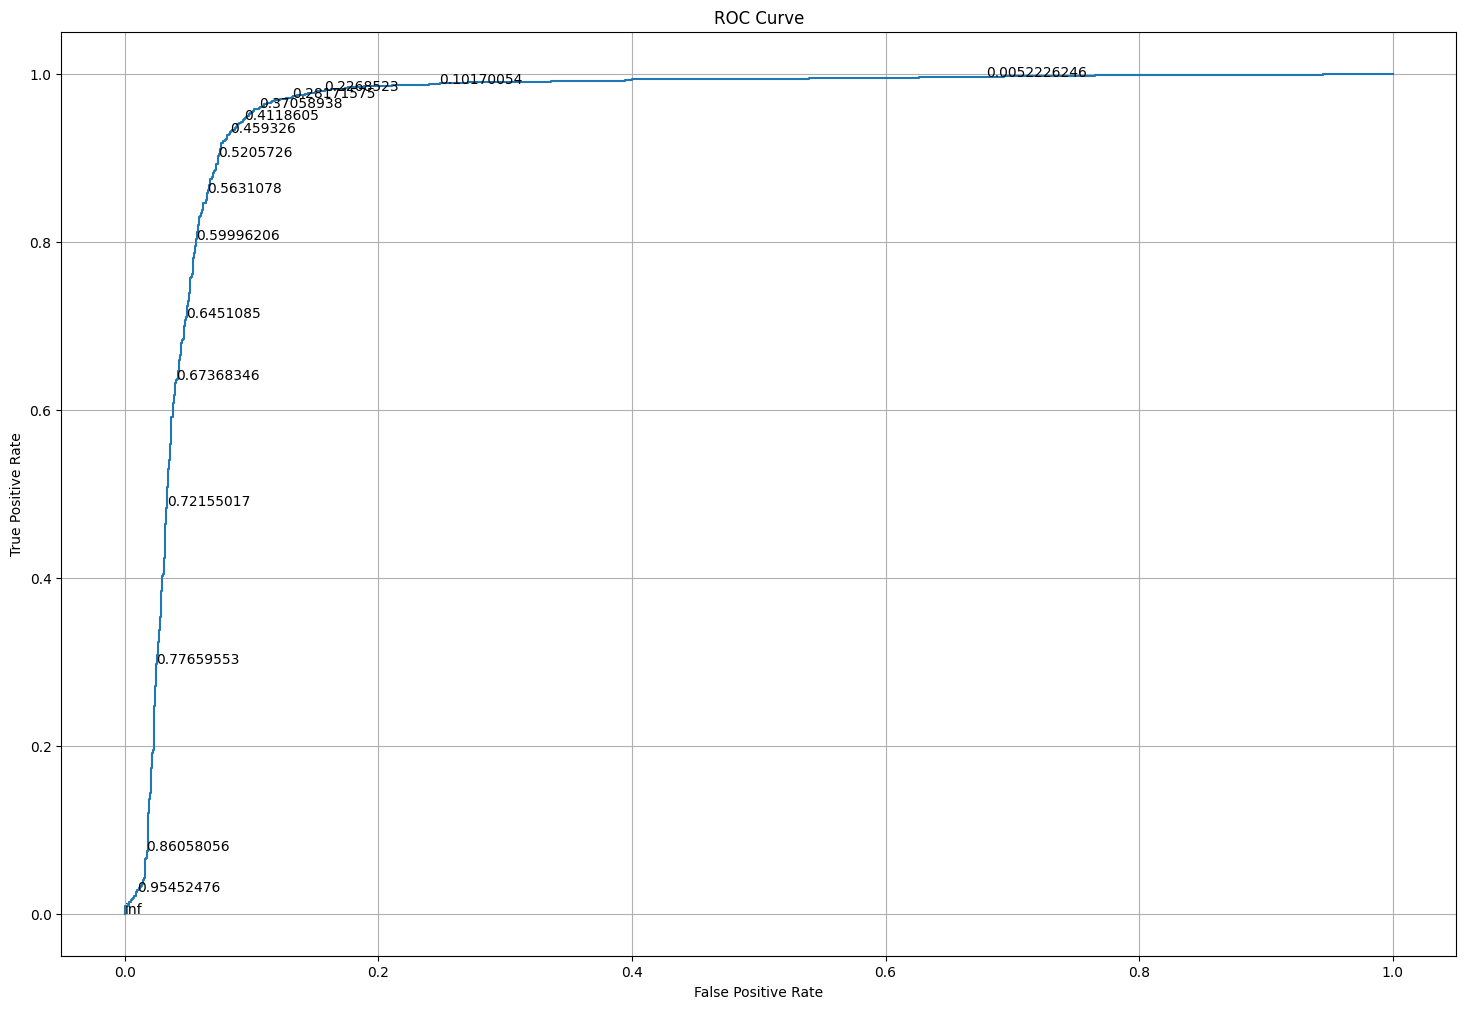

In [21]:
plt.figure(figsize=(18,12))
plt.plot(fpr,tpr)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()

for i in np.arange(0,len(thresholds),30):
    plt.text(fpr[i],tpr[i],thresholds[i])

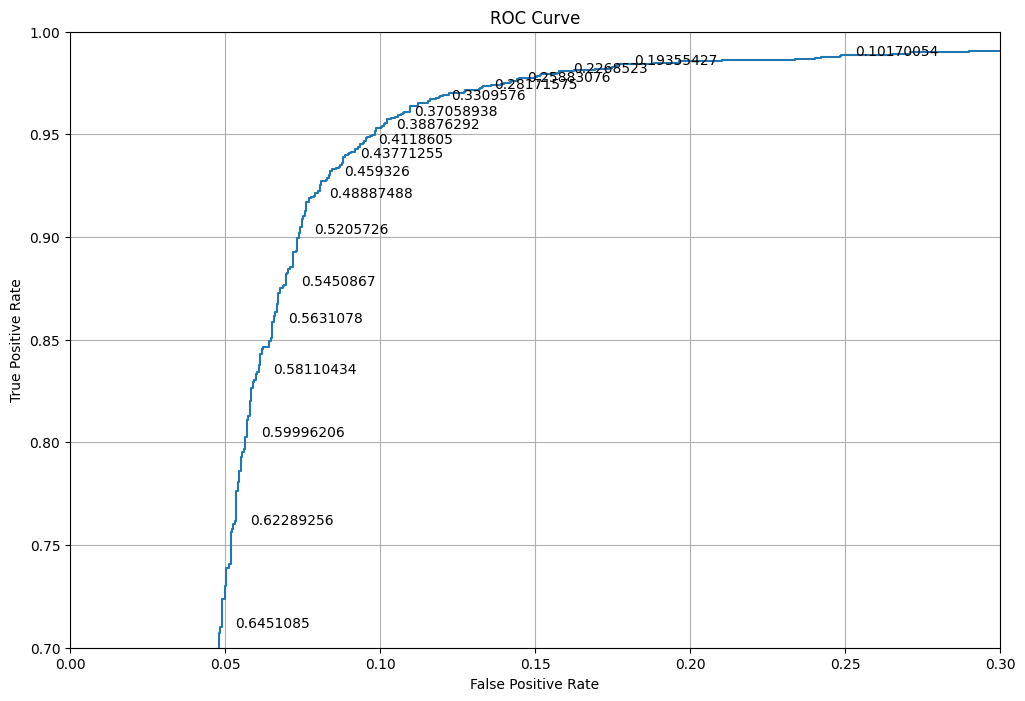

In [22]:
plt.figure(figsize=(12,8))
plt.plot(fpr,tpr)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.xlim(0.0,0.3)
plt.ylim(0.7,1.0)

for i in np.arange(0,len(thresholds),15):
    if fpr[i] < 0.3 and tpr[i] > 0.7:
        plt.text(fpr[i]+0.005,tpr[i],thresholds[i])
    

Text(0.5, 14.722222222222216, 'Predicted')

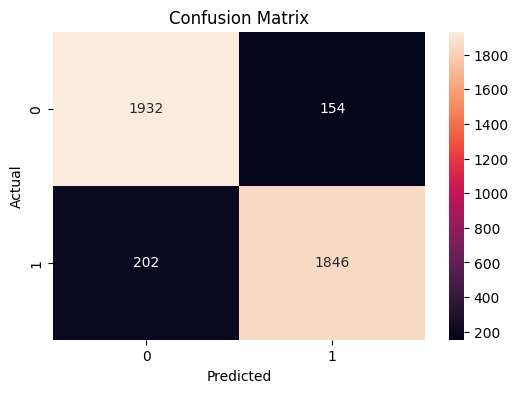

In [23]:
# in order to reduce the FP, 
# we can choose a threshold of 0.5205726 , that could reduce FPR while reasonably maintaining TPR

conf_mtrx = confusion_matrix(y_true=actual_y, y_pred=(pred_y>0.5205726))

plt.figure(figsize=(6,4))
sns.heatmap(conf_mtrx,annot=True,fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')


___

## CallBacks : CSVLogger

In [24]:
from tensorflow.keras.callbacks import CSVLogger

In [25]:
# in order to stor model performance info into a csv file

csv_logger = CSVLogger(filename='Malaria_Detection_logs.csv',append=False) 
                                                    # append = False as file doesnt exist and need to be created
                                                    # append = True for continuing/adding to previous training records
        

In [26]:
cv_set = cv_set.map(image_resize)
cv_set = cv_set.batch(batch_size=64).cache().prefetch(tf.data.AUTOTUNE)

In [27]:
model.fit(cv_set,epochs=3,callbacks=[csv_logger],validation_data=test_set)

Epoch 1/3
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 161ms/step - BinAcc: 0.9197 - auc: 0.9637 - fn: 25.8261 - fp: 36.3043 - loss: 0.2692 - precision: 0.8948 - recall: 0.9410 - tn: 355.8261 - tp: 344.6522 - val_BinAcc: 0.9294 - val_auc: 0.9590 - val_fn: 112.0000 - val_fp: 180.0000 - val_loss: 0.3074 - val_precision: 0.9149 - val_recall: 0.9453 - val_tn: 1906.0000 - val_tp: 1936.0000
Epoch 2/3
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - BinAcc: 0.9205 - auc: 0.9729 - fn: 11.7391 - fp: 45.2174 - loss: 0.2725 - precision: 0.8721 - recall: 0.9750 - tn: 346.9131 - tp: 358.7391 - val_BinAcc: 0.9253 - val_auc: 0.9633 - val_fn: 108.0000 - val_fp: 201.0000 - val_loss: 0.2582 - val_precision: 0.9061 - val_recall: 0.9473 - val_tn: 1885.0000 - val_tp: 1940.0000
Epoch 3/3
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - BinAcc: 0.9162 - auc: 0.9571 - fn: 21.6087 - fp: 41.0000 - loss: 0.2894 - precision: 0.8810 - recall: 0.9520 - tn: 351.1304 - tp: 348.8696 - val_BinAcc: 0.8732 - val_auc: 0.9423 - val_fn: 34.0000 - val

In [28]:
import pandas as pd

In [29]:
model_performance = pd.read_csv('Malaria_Detection_logs.csv')
model_performance

epoch    BinAcc       auc    fn    fp      loss  precision    recall  \
0      0  0.912917  0.950920  50.0  70.0  0.324527   0.900568  0.926901   
1      1  0.925254  0.961250  25.0  78.0  0.277639   0.894166  0.963450   
2      2  0.919448  0.952159  40.0  71.0  0.291429   0.900699  0.941520   

      tn     tp  val_BinAcc   val_auc  val_fn  val_fp  val_loss  \
0  624.0  634.0    0.929366  0.958968   112.0   180.0  0.307351   
1  616.0  659.0    0.925254  0.963257   108.0   201.0  0.258210   
2  623.0  644.0    0.873246  0.942336    34.0   490.0  0.374767   

   val_precision  val_recall  val_tn  val_tp  
0       0.914934    0.945312  1906.0  1936.0  
1       0.906119    0.947266  1885.0  1940.0  
2       0.804313    0.983398  1596.0  2014.0

## CallBacks : Early stopping

In [30]:
from tensorflow.keras.callbacks import EarlyStopping

In [31]:
es_callback = EarlyStopping(monitor='val_loss', patience=2, min_delta=0.5, restore_best_weights=True)

# monitor -> tracks the metric like loss/validation loss/precision
# patience -> number of continuous epochs required to stop training if there is no improvement
# min_delta -> minimum change in monitoring metric to be considered as an improvement

In [32]:
model.load_weights('SavedWeights/Malaria_Randomly_Initialized.weights.h5')

/opt/anaconda3/envs/tf_env/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 38 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [33]:
history = model.fit(cv_set,epochs=50,callbacks=[csv_logger,es_callback],validation_data=cv_set)

Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - BinAcc: 0.5466 - auc: 0.5576 - fn: 181.3044 - fp: 158.8696 - loss: 0.7885 - precision: 0.5217 - recall: 0.5139 - tn: 233.2609 - tp: 189.1739 - val_BinAcc: 0.4964 - val_auc: 0.5000 - val_fn: 0.0000e+00 - val_fp: 694.0000 - val_loss: 7.8450 - val_precision: 0.4964 - val_recall: 1.0000 - val_tn: 0.0000e+00 - val_tp: 684.0000
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - BinAcc: 0.6449 - auc: 0.6998 - fn: 119.0435 - fp: 149.5217 - loss: 0.6370 - precision: 0.6114 - recall: 0.6808 - tn: 242.6087 - tp: 251.4348 - val_BinAcc: 0.4964 - val_auc: 0.7043 - val_fn: 0.0000e+00 - val_fp: 694.0000 - val_loss: 1.4507 - val_precision: 0.4964 - val_recall: 1.0000 - val_tn: 0.0000e+00 - val_tp: 684.0000
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - BinAcc: 0.6865 - auc: 0.7419 - fn: 107.6957 - fp: 134.5217 - loss: 0.6074 - precision: 0.6513 - recall: 0.7267 - tn: 257.6087 - tp: 262.7826 - val_BinAcc: 0.4964 - val_auc: 0.6819 - val_fn: 0.0

In [36]:
history.history['val_loss']

[7.8449578285217285, 1.4506536722183228, 1.091860294342041, 1.4467209577560425]

delta is set to 0.5, 

Epoch 1 - N/A

Epoch 2 - 0.5+ improvement

Epoch 3 - <0.5 , so patience=1

Epoch 4 - <0.5 , so patience=2 and hence terminates

## CallBacks : Learning Rate Scheduler

Used to modify (generally reduce) the learning rate after some epochs so that the gradient descent/loss could reach global minimum

In [38]:
from tensorflow.keras.callbacks import LearningRateScheduler

In [46]:
def schedule_learn_rate(epoch, learn_rate):
    if epoch < 3:
        return learn_rate
    else:
        return learn_rate*0.1 #reducing the learning rate by 1/10th

In [47]:
scheduler = LearningRateScheduler(schedule=schedule_learn_rate, verbose=1)

In [49]:
model.compile(optimizer=Adam(learning_rate=0.1), #keeping higer rate, as it will get reduced
             loss=BinaryCrossentropy(),
             metrics=metrics)

In [50]:
model.fit(cv_set, epochs=5, callbacks=[scheduler], validation_data=test_set)


Epoch 1: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 1/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 163ms/step - BinAcc: 0.6352 - auc: 0.6912 - fn: 520.2609 - fp: 1264.0435 - loss: 0.6284 - precision: 0.5998 - recall: 0.7858 - tn: 1214.0869 - tp: 1898.2174 - val_BinAcc: 0.5375 - val_auc: 0.6355 - val_fn: 68.0000 - val_fp: 1844.0000 - val_loss: 2.9155 - val_precision: 0.5178 - val_recall: 0.9668 - val_tn: 242.0000 - val_tp: 1980.0000 - learning_rate: 0.1000

Epoch 2: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 2/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - BinAcc: 0.7650 - auc: 0.8455 - fn: 75.8696 - fp: 103.3043 - loss: 0.4907 - precision: 0.7317 - recall: 0.7907 - tn: 288.8261 - tp: 294.6087 - val_BinAcc: 0.4990 - val_auc: 0.5098 - val_fn: 3.0000 - val_fp: 2068.0000 - val_loss: 12.3917 - val_precision: 0.4972 - val_recall: 0.9985 - val_tn: 18.0000 - val_tp: 2045.0000 - learning_rate: 0.1000

Epoch 3: LearningRateScheduler setting learnin

## CallBacks : Model Checkpoint

to save the best performing model from the training

In [51]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [52]:
import os
os.makedirs('ModelCheckpoints')

In [53]:
model_checkpoint = ModelCheckpoint(filepath='ModelCheckpoints/Malaria_model_checkpoint.weights.h5', 
                                   monitor='BinAcc', verbose=1, save_best_only=True,
                                   save_weights_only=True, save_freq='epoch')
                                    # 'epoch' saves after each epoch. 
                                    # An integer saves after every N batches -> less mature model 

In [54]:
es_callback = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

In [57]:
model.load_weights('SavedWeights/Malaria_Randomly_Initialized.weights.h5')

/opt/anaconda3/envs/tf_env/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 38 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [58]:
history = model.fit(cv_set, epochs=25, callbacks=[model_checkpoint,csv_logger,es_callback], 
                    validation_data=test_set)

Epoch 1/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - BinAcc: 0.5597 - auc: 0.5863 - fn: 163.4545 - fp: 159.1364 - loss: 0.7605 - precision: 0.5325 - recall: 0.5484 - tn: 219.2727 - tp: 192.7727
Epoch 1: BinAcc improved from 0.88679 to 0.57547, saving model to ModelCheckpoints/Malaria_model_checkpoint.weights.h5
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - BinAcc: 0.5604 - auc: 0.5873 - fn: 169.6956 - fp: 164.3044 - loss: 0.7585 - precision: 0.5344 - recall: 0.5485 - tn: 227.8261 - tp: 200.7826 - val_BinAcc: 0.4959 - val_auc: 0.6711 - val_fn: 1.0000 - val_fp: 2083.0000 - val_loss: 0.7764 - val_precision: 0.4956 - val_recall: 0.9995 - val_tn: 3.0000 - val_tp: 2047.0000
Epoch 2/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - BinAcc: 0.7109 - auc: 0.7687 - fn: 104.7727 - fp: 117.2273 - loss: 0.5882 - precision: 0.6797 - recall: 0.7360 - tn: 261.1818 - tp: 251.4545
Epoch 2: BinAcc did not improve from 0.57547
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - BinAcc: 0.7096 - auc: 0.7675 - fn: 109.6522 

In [59]:
history.history['val_loss']

[0.7763621211051941,
 0.7498645782470703,
 0.6950330138206482,
 0.7468301653862,
 0.8461745977401733,
 1.0662271976470947]

## CallBacks : Reduce Learning Rate on Plateau

In [60]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

to reduce the learning rate in case of no improvement in the loss/metrics

In [131]:
lr_plateau = ReduceLROnPlateau(monitor='val_BinAcc',patience=3, # wait for 3 epochs on whether to take action
                               factor=0.5, # multiplicative reduction in the learning rate
                               verbose=1, cooldown=5, # number of epochs to wait before activating this function again 
                               min_lr=0.001, # not to take lr below this threshold 
                               min_delta=0.1) # not considered as improvement if change is metric is lesser than this


In [132]:
model.load_weights('SavedWeights/Malaria_Randomly_Initialized.weights.h5')

In [135]:
model.compile(optimizer=Adam(learning_rate=1.0),
             loss=BinaryCrossentropy(),
             metrics=metrics)

In [136]:
history = model.fit(cv_set, epochs=15, callbacks=[lr_plateau], validation_data=test_set)

Epoch 1/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 201ms/step - BinAcc: 0.5143 - auc: 0.5244 - fn: 2217.9131 - fp: 159.1304 - loss: 6.7351 - precision: 0.5750 - recall: 0.0794 - tn: 2319.0000 - tp: 200.5652 - val_BinAcc: 0.4954 - val_auc: 0.5000 - val_fn: 0.0000e+00 - val_fp: 2086.0000 - val_loss: 106.7904 - val_precision: 0.4954 - val_recall: 1.0000 - val_tn: 0.0000e+00 - val_tp: 2048.0000 - learning_rate: 1.0000
Epoch 2/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step - BinAcc: 0.5196 - auc: 0.5164 - fn: 189.3044 - fp: 162.3044 - loss: 3.8772 - precision: 0.4769 - recall: 0.4371 - tn: 229.8261 - tp: 181.1739 - val_BinAcc: 0.4954 - val_auc: 0.5007 - val_fn: 0.0000e+00 - val_fp: 2086.0000 - val_loss: 43.6782 - val_precision: 0.4954 - val_recall: 1.0000 - val_tn: 0.0000e+00 - val_tp: 2048.0000 - learning_rate: 1.0000
Epoch 3/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - BinAcc: 0.6018 - auc: 0.6548 - fn: 150.0000 - fp: 161.0870 - loss: 1.0346 - precision: 0.5760 - recall: 0.5956 - tn: 231.0435 - tp: 2

In [139]:
np.set_printoptions(precision=3)

In [141]:
for i,loss,lr in zip(np.arange(1,16),history.history['val_BinAcc'],history.history['learning_rate']):
    print(f'Epoch : {i}\tValidation Accuracy : {loss:.3f}\tLearning Rate : {lr}')

Epoch : 1	Validation Accuracy : 0.495	Learning Rate : 1.0
Epoch : 2	Validation Accuracy : 0.495	Learning Rate : 1.0
Epoch : 3	Validation Accuracy : 0.416	Learning Rate : 1.0
Epoch : 4	Validation Accuracy : 0.495	Learning Rate : 1.0
Epoch : 5	Validation Accuracy : 0.496	Learning Rate : 0.5
Epoch : 6	Validation Accuracy : 0.527	Learning Rate : 0.5
Epoch : 7	Validation Accuracy : 0.510	Learning Rate : 0.5
Epoch : 8	Validation Accuracy : 0.550	Learning Rate : 0.5
Epoch : 9	Validation Accuracy : 0.530	Learning Rate : 0.5
Epoch : 10	Validation Accuracy : 0.530	Learning Rate : 0.5
Epoch : 11	Validation Accuracy : 0.538	Learning Rate : 0.5
Epoch : 12	Validation Accuracy : 0.549	Learning Rate : 0.25
Epoch : 13	Validation Accuracy : 0.616	Learning Rate : 0.25
Epoch : 14	Validation Accuracy : 0.648	Learning Rate : 0.25
Epoch : 15	Validation Accuracy : 0.567	Learning Rate : 0.25


Working of Cooldown - Patience - Delta 
 
Epoch 5 (0.496): This is considered an improvement over 0.495 (even though it's less than min_delta). The new best accuracy is set to 0.496, and the patience counter is reset to 0.

Epoch 6 (0.527): An improvement. New best accuracy: 0.527. Patience counter is reset to 0.

Epoch 7 (0.510): Not an improvement over 0.527. Patience count = 1.

Epoch 8 (0.550): An improvement. New best accuracy: 0.550. Patience counter is reset to 0.

Epoch 9 (0.530): Not an improvement over 0.550 (which would require a value > 0.650 due to min_delta). Patience count = 1.

Epoch 10 (0.530): Not an improvement. Patience count = 2.

Epoch 11 (0.538): Not an improvement. Patience count = 3.

Action: The patience of 3 was met at the end of epoch 11. Even though the cooldown had ended, the callback was now triggered. The learning rate was reduced from 0.5 to 0.25 for use in the next epoch, which is epoch 12.

## Regularization

* Dropout : Way of regularization by temporarily dropping random neurons from the network

* Kernel Regularization : 
    * L1 - Absolute value of sum of weights $\sum_{i=1}^{N} |w_i|$
    * L2 - Squared sum of weights $\sum_{i=1}^{N} w_i^{2}$

## Model 2

In [1]:
from tensorflow.keras.layers import Dropout, SpatialDropout2D
# Dropout drops out individual neurons
# SpatialDropout2D drops out entire filter (channel)

from tensorflow.keras.regularizers import L1,L2

In [6]:
model = tf.keras.Sequential([
    InputLayer(shape=(224,224,3)),
    Conv2D(filters=8, kernel_size=(4,4), strides=(2,2), padding='valid',activation='relu',
           kernel_regularizer=L2(l2=0.005)), # L2 regulariser with rate 0.005
    BatchNormalization(),
    
    MaxPool2D(pool_size=(2,2), strides=(2,2)),
    
    Conv2D(filters=18, kernel_size=(3,3), strides=(1,1), padding='valid',activation='relu'),
    BatchNormalization(), 
    SpatialDropout2D(rate=0.20), # drops 20% of the number of channels
    
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    
    Flatten(),
    
    Dense(units=125,activation='relu'),
    BatchNormalization(),
    Dropout(rate=0.20), # drops 20% of the number of neurons
    
    Dense(units=70,activation='relu', kernel_regularizer=L2(0.005)),
    BatchNormalization(),

    
    Dense(units=1,activation='sigmoid')   
])

In [6]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 111, 111, 8)    │           392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 111, 111, 8)    │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 55, 55, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 53, 53, 18)     │         1,314 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 53, 53, 18)     │            72 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d               │ (None, 53, 53, 18)     │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 26, 26, 18)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12168)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 125)            │     1,521,125 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 125)            │           500 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 125)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 70)             │         8,820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 70)             │           280 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            71 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,532,606 (5.85 MB)

 Trainable params: 1,532,164 (5.84 MB)

 Non-trainable params: 442 (1.73 KB)

In [9]:
csv_logger = CSVLogger(filename='Malaria_Detection_logs.csv',append=False)

es_callback = EarlyStopping(monitor='val_BinAcc', patience=5, restore_best_weights=True, verbose=1)

lr_plateau = ReduceLROnPlateau(monitor='val_loss',patience=3, 
                               factor=0.5,
                               verbose=1, 
                               min_lr=0.001)

model_checkpoint = ModelCheckpoint(filepath='ModelCheckpoints/Malaria_model_checkpoint.weights.h5', 
                                   monitor='val_BinAcc', verbose=1, save_best_only=True,
                                   save_weights_only=True, save_freq='epoch',mode='max')

In [7]:
metrics = [TruePositives(name='tp'), TrueNegatives(name='tn'), FalsePositives(name='fp'), FalseNegatives(name='fn'),
          BinaryAccuracy(name='BinAcc'), Precision(name='precision'), Recall(name='recall')]

model.compile(loss=BinaryCrossentropy(), optimizer=Adam(learning_rate=0.1), metrics=metrics)


In [11]:
model.fit(train_set,epochs=20,callbacks=[csv_logger,model_checkpoint,lr_plateau,es_callback],
          validation_data=cv_set)

Epoch 1/20


2025-08-13 23:04:34.884108: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - BinAcc: 0.6103 - fn: 1944.6377 - fp: 2329.6753 - loss: 1.0734 - precision: 0.6062 - recall: 0.6491 - tn: 3177.9392 - tp: 3619.6492
Epoch 1: val_BinAcc improved from -inf to 0.50363, saving model to ModelCheckpoints/Malaria_model_checkpoint.weights.h5
345/345 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - BinAcc: 0.6103 - fn: 1949.8179 - fp: 2336.1099 - loss: 1.0728 - precision: 0.6062 - recall: 0.6491 - tn: 3187.3757 - tp: 3630.3149 - val_BinAcc: 0.5036 - val_fn: 684.0000 - val_fp: 0.0000e+00 - val_loss: 3.0589 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 694.0000 - val_tp: 0.0000e+00 - learning_rate: 0.1000
Epoch 2/20
345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - BinAcc: 0.5858 - fn: 2210.5508 - fp: 2497.3508 - loss: 0.8061 - precision: 0.5822 - recall: 0.6261 - tn: 3010.2637 - tp: 3353.7363
Epoch 2: val_BinAcc did not improve from 0.50363
345/345 ━━━━━━━━━━━━━━━━━━━━ 57s 164ms/step - BinAcc: 0.5857 - fn: 2217.4365 - fp: 2504.7600 - l

In [12]:
import pandas as pd

model_performance = pd.read_csv('Malaria_Detection_logs.csv')
model_performance

epoch    BinAcc      fn      fp      loss  precision    recall      tn  \
0       0  0.623832  3737.0  4556.0  0.845218   0.616046  0.661718  6443.0   
1       1  0.562097  4593.0  5061.0  0.766880   0.560486  0.584231  5938.0   
2       2  0.584913  4326.0  4825.0  0.722749   0.582106  0.608400  6174.0   
3       3  0.615486  4074.0  4403.0  0.721604   0.612957  0.631212  6596.0   
4       4  0.755647  2009.0  3378.0  0.660703   0.727932  0.818141  7621.0   
5       5  0.763177  1998.0  3223.0  0.693757   0.737370  0.819136  7776.0   
6       6  0.857979   921.0  2210.0  0.627673   0.820850  0.916629  8789.0   
7       7  0.864873   931.0  2048.0  0.737369   0.831634  0.915724  8951.0   
8       8  0.846321  1124.0  2264.0  0.838744   0.814228  0.898253  8735.0   
9       9  0.869727   843.0  2029.0  0.890936   0.834137  0.923690  8970.0   
10     10  0.876848   767.0  1948.0  0.952291   0.840693  0.930569  9051.0   
11     11  0.875034   771.0  1984.0  1.078071   0.838173  0.930207  9015.0   
12     12  0.879071   792.0  1874.0  1.123733   0.845494  0.928306  9125.0   
13     13  0.891726   611.0  1776.0  1.176706   0.854569  0.944691  9223.0   
14     14  0.893994   659.0  1678.0  1.170781   0.860932  0.940346  9321.0   
15     15  0.895038   618.0  1696.0  1.240951   0.860124  0.944057  9303.0   
16     16  0.896081   607.0  1684.0  1.279180   0.861102  0.945053  9315.0   
17     17  0.895763   592.0  1706.0  1.296876   0.859715  0.946411  9293.0   
18     18  0.898167   576.0  1669.0  1.316444   0.862521  0.947859  9330.0   
19     19  0.901842   556.0  1608.0  1.338482   0.867096  0.949670  9391.0   

         tp  val_BinAcc  val_fn  val_fp  val_loss  val_precision  val_recall  \
0    7310.0    0.503628   684.0     0.0  3.058858       0.000000    0.000000   
1    6454.0    0.503628   684.0     0.0  0.819200       0.000000    0.000000   
2    6721.0    0.497823     2.0   690.0  0.741240       0.497085    0.997076   
3    6973.0    0.503628   684.0     0.0  1.134396       0.000000    0.000000   
4    9038.0    0.753266    43.0   297.0  1.434879       0.683369    0.937135   
5    9049.0    0.507257     0.0   679.0  0.863693       0.501834    1.000000   
6   10126.0    0.915094    40.0    77.0  0.617488       0.893204    0.941520   
7   10116.0    0.905660    76.0    54.0  0.918565       0.918429    0.888889   
8    9923.0    0.846154    17.0   195.0  0.915761       0.773782    0.975146   
9   10204.0    0.763425   271.0    55.0  2.234602       0.882479    0.603801   
10  10280.0    0.878084    29.0   139.0  1.059738       0.824937    0.957602   
11  10276.0    0.924528    32.0    72.0  1.163249       0.900553    0.953216   
12  10255.0    0.924528    42.0    62.0  1.272024       0.911932    0.938596   
13  10436.0    0.917271    25.0    89.0  1.174252       0.881016    0.963450   
14  10388.0    0.925254    44.0    59.0  1.285343       0.915594    0.935673   
15  10429.0    0.925980    24.0    78.0  1.253391       0.894309    0.964912   
16  10440.0    0.937591    46.0    40.0  1.359832       0.941003    0.932749   
17  10455.0    0.927431    35.0    65.0  1.355732       0.908964    0.948830   
18  10471.0    0.923077    40.0    66.0  1.368065       0.907042    0.941520   
19  10491.0    0.917271    29.0    85.0  1.336718       0.885135    0.957602   

    val_tn  val_tp  
0    694.0     0.0  
1    694.0     0.0  
2      4.0   682.0  
3    694.0     0.0  
4    397.0   641.0  
5     15.0   684.0  
6    617.0   644.0  
7    640.0   608.0  
8    499.0   667.0  
9    639.0   413.0  
10   555.0   655.0  
11   622.0   652.0  
12   632.0   642.0  
13   605.0   659.0  
14   635.0   640.0  
15   616.0   660.0  
16   654.0   638.0  
17   629.0   649.0  
18   628.0   644.0  
19   609.0   655.0

In [13]:
model.evaluate(test_set,return_dict=True)

65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - BinAcc: 0.9287 - fn: 67.8485 - fp: 81.2576 - loss: 1.3454 - precision: 0.9196 - recall: 0.9326 - tn: 1013.0606 - tp: 980.0757


{'BinAcc': 0.9313014149665833,
 'fn': 132.0,
 'fp': 152.0,
 'loss': 1.3239611387252808,
 'precision': 0.9264990091323853,
 'recall': 0.935546875,
 'tn': 1934.0,
 'tp': 1916.0}

## Data Augmentation

Adding more data sample to the training set by modifying the data

tf.image has several operations on an image,

* adjust_brightness, random_brightness
* adjust_contrast, random_contrast
* adjust_gamma
* adjust_hue, random_hue
* adjust_saturation, random_saturation
* flip_left_right, random_flip_left_right
* flip_up_down, random_flip_up_down
* rot90

In [15]:
import matplotlib.pyplot as plt

def visualize_sample(original, augmented):
    plt.subplot(1,2,1)
    plt.imshow(original)
    
    plt.subplot(1,2,2)
    plt.imshow(augmented)

In [44]:
orgnl_img = next(iter(train_set))[0][50]

In [45]:
agmntd_img = tf.image.adjust_brightness(orgnl_img, delta=0.2)

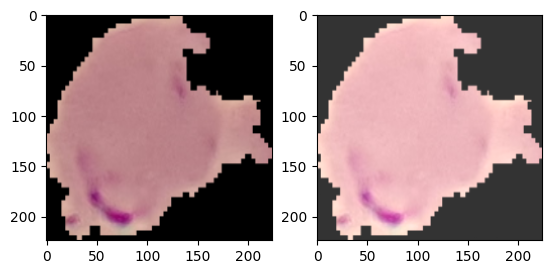

In [46]:
visualize_sample(orgnl_img,agmntd_img)

In [47]:
agmntd_img = tf.image.adjust_contrast(orgnl_img, contrast_factor=0.5)

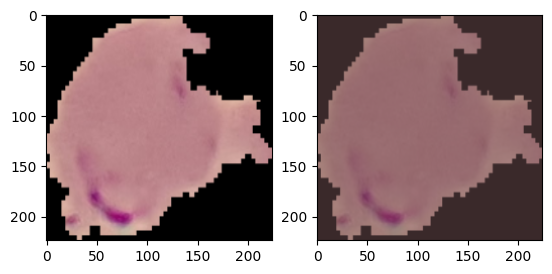

In [48]:
visualize_sample(orgnl_img,agmntd_img)

In [51]:
agmntd_img = tf.image.adjust_gamma(orgnl_img, gamma=2)

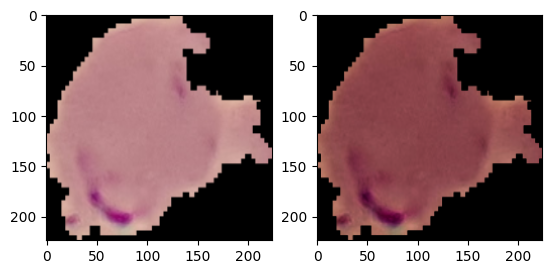

In [52]:
visualize_sample(orgnl_img, agmntd_img)

In [53]:
agmntd_img = tf.image.adjust_gamma(orgnl_img, gamma=0.3)

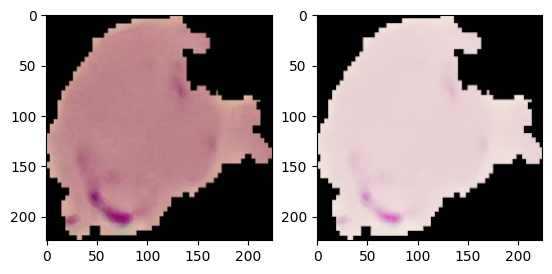

In [54]:
visualize_sample(orgnl_img,agmntd_img)

In [57]:
agmntd_img = tf.image.adjust_saturation(orgnl_img, saturation_factor=2)

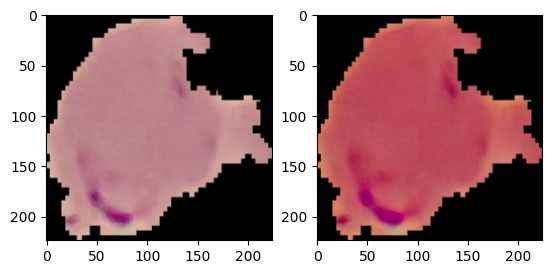

In [58]:
visualize_sample(orgnl_img,agmntd_img)

In [59]:
agmntd_img = tf.image.rot90(orgnl_img)

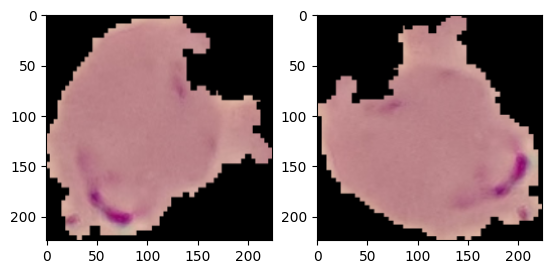

In [60]:
visualize_sample(orgnl_img,agmntd_img)

In [61]:
agmntd_img = tf.image.rot90(orgnl_img, k=3)

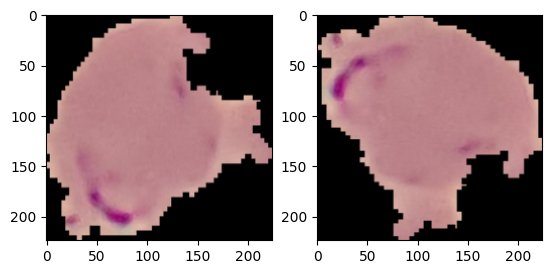

In [62]:
visualize_sample(orgnl_img,agmntd_img)

In [63]:
agmntd_img = tf.image.flip_left_right(orgnl_img)

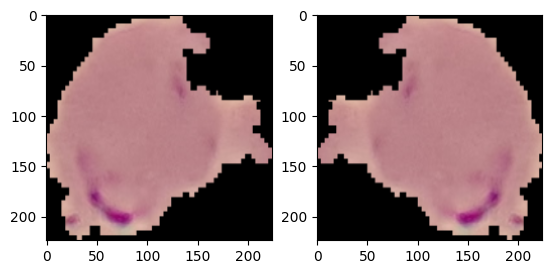

In [64]:
visualize_sample(orgnl_img,agmntd_img)

In [65]:
agmntd_img = tf.image.flip_up_down(orgnl_img)

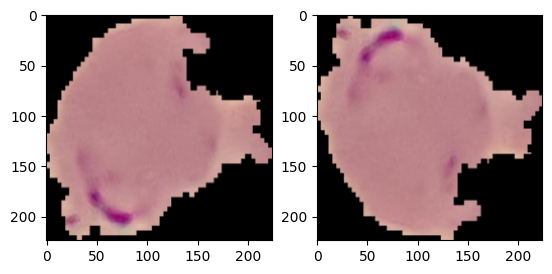

In [66]:
visualize_sample(orgnl_img,agmntd_img)

In [67]:
agmntd_img = tf.image.central_crop(orgnl_img, central_fraction=0.8)

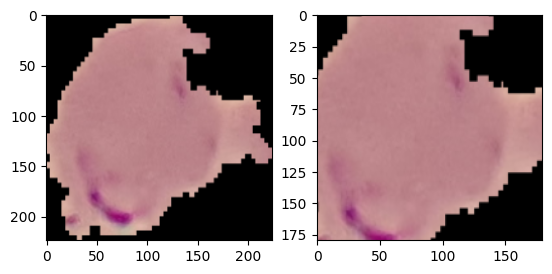

In [68]:
visualize_sample(orgnl_img,agmntd_img)

In [75]:
agmntd_img = tf.image.crop_to_bounding_box(orgnl_img, offset_height=100,offset_width=10,
                                           target_height=124,target_width=100)

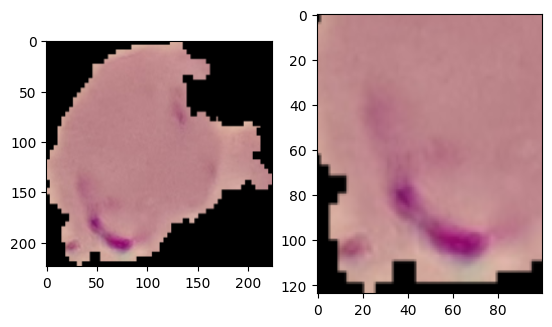

In [76]:
visualize_sample(orgnl_img,agmntd_img)

tf.keras.layers also has some operations on data augmentation, but not as flexible as tf.image operations
* RandomSaturation 
* RandomContrast
* RandomFlip
* RandomRotation

In [79]:
from tensorflow.keras.layers import RandomSaturation, RandomContrast, RandomFlip, RandomRotation

In [142]:
# creating a pipeline of data augmentation

agmnt_sqnce = tf.keras.Sequential([
    RandomContrast(factor=(0.3,0.8)), # randomly picks value between 2 & 3
    RandomSaturation(factor=(0.3,0.7)), # randomly picks value between 0.6 & 1
    RandomFlip(mode='horizontal_and_vertical'), # Sometimes vertical, sometimes horizontal, sometimes both, 
                                               # sometimes none (each chosen independently per image)
    RandomRotation(factor=(-0.25,0.25), # => rotation angle is randomlypicked between (-0.25*360, 0.25*360) i.e (-90,90)
                   fill_mode='constant',fill_value=0) # fill the blank pixels after rotation 0=black 255=white
])

In [143]:
def augment_data(image, label):
    return agmnt_sqnce(image), label

In [156]:
agmntd_data = train_set.take(1).map(augment_data)

2025-08-17 17:11:24.516136: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


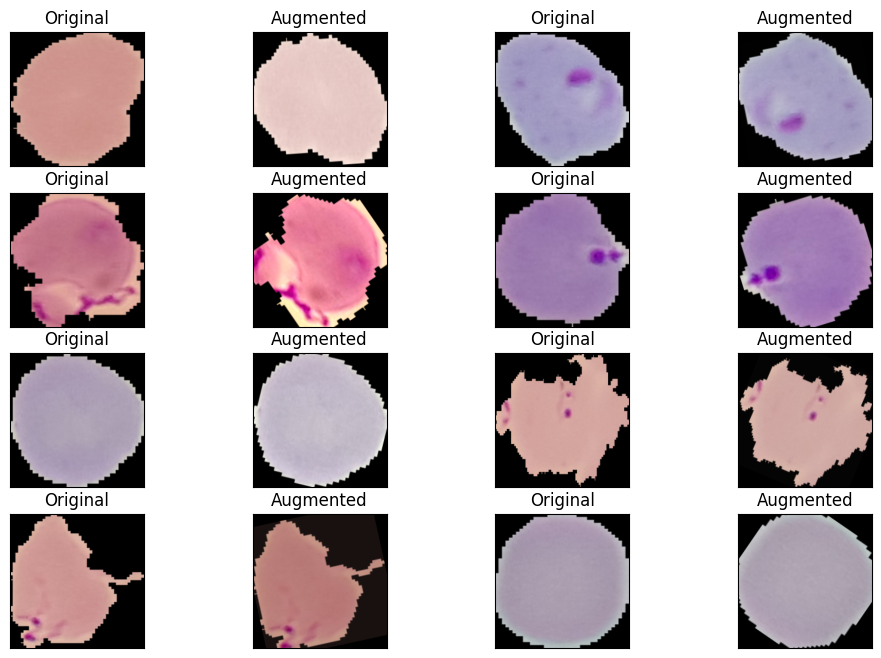

In [157]:
for original, augmented in zip(train_set.take(1),agmntd_data):
    plt.figure(figsize=(12,8))
    for i in range(0,16,2):
        ax = plt.subplot(4,4,i+1)
        plt.imshow(original[0][i])
        plt.title('Original')
        plt.xticks(ticks=[])
        plt.yticks(ticks=[])
        
        ax = plt.subplot(4,4,i+2)
        plt.imshow(tf.clip_by_value(augmented[0][i], 0.0, 1.0))
        plt.title('Augmented')
        plt.xticks(ticks=[])
        plt.yticks(ticks=[])

The main reason to go for random augmentation functions is to have a sample with varied with features like contrast, saturation, rotation, flip,... making a new sample out of existing for every epoch, rather than creating and storing the augmented sample which increases the storage and training time making the training inefficient.

## Data Mix Up 

This is another kind of data augmentation to merge/overlay 2 random samples in order to introduce noise.

A random number $\lambda$ is picked from the Beta distribution curve to determine the overlay factor.

Augmented sample = ($\lambda$ * Sample 1) + ((1 - $\lambda$) * Sample 2)

We use Beta distribution curve because, with $\alpha$ and $\beta$ equal to 0.2 or 0.4, 
we get a curve with higher probability for getting $\lambda$ value close to 0 or 1, which cleates more samples with noise rather than samples with perfect blend

In [7]:
import tensorflow_probability as tfp

In [76]:
lmbda = tfp.distributions.Beta(0.2,0.2)
lmbda = lmbda.sample(1)
lmbda

2025-08-18 18:17:42.422451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-08-18 18:17:42.435064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-08-18 18:17:42.436824: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-08-18 18:17:42.437673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-08-18 18:17:42.443814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-08-18 18:17:42.444829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.8977922], dtype=float32)>

In [30]:
images = next(iter(train_set.take(1)))
image_1 = images[0][0]
image_2 = images[0][35]

2025-08-18 18:01:53.158712: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [31]:
label_1 = images[1][0]
label_2 = images[1][35]

In [40]:
def convert_label(label):
    if label==0:
        return 'P'  # parasitized
    else:
        return 'U'  # uninfected

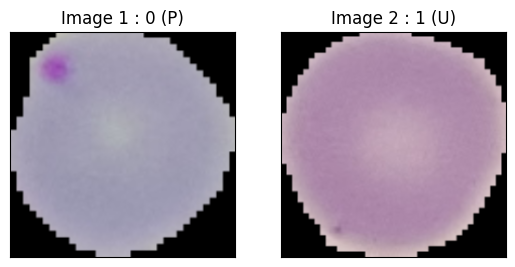

In [47]:
import matplotlib.pyplot as plt

ax = plt.subplot(1,2,1)
plt.imshow(image_1)
plt.yticks(ticks=[])
plt.xticks(ticks=[])
plt.title('Image 1 : '+str(label_1.numpy())+' ('+convert_label(label_1.numpy())+')')

ax = plt.subplot(1,2,2)
plt.imshow(image_2)
plt.yticks(ticks=[])
plt.xticks(ticks=[])
plt.title('Image 2 : '+str(label_2.numpy())+' ('+convert_label(label_2.numpy())+')')

plt.show()

In [77]:
mix_up_img = lmbda.numpy()[0]*image_1 + (1-lmbda.numpy()[0])*image_2
mix_up_lbl = lmbda.numpy()[0]*label_1.numpy() + (1-lmbda.numpy()[0])*label_2.numpy()

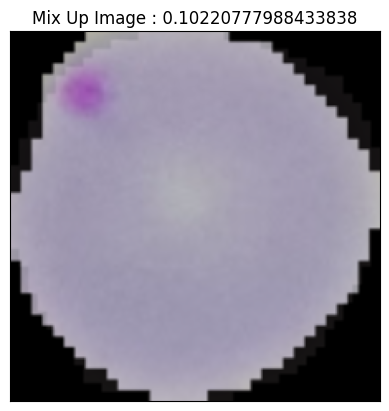

In [78]:
plt.imshow(mix_up_img)
plt.yticks(ticks=[])
plt.xticks(ticks=[])
plt.title('Mix Up Image : '+str(mix_up_lbl))
plt.show()

In [88]:
lmbda = tfp.distributions.Beta(0.2,0.2)
lmbda = lmbda.sample(1)
lmbda

2025-08-18 18:18:58.601399: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-08-18 18:18:58.613789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-08-18 18:18:58.615560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-08-18 18:18:58.616431: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-08-18 18:18:58.624247: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-08-18 18:18:58.625373: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.48745787], dtype=float32)>

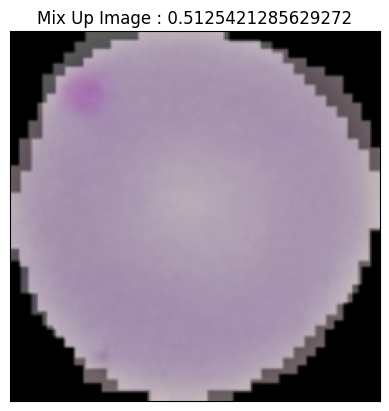

In [90]:
mix_up_img = lmbda.numpy()[0]*image_1 + (1-lmbda.numpy()[0])*image_2
mix_up_lbl = lmbda.numpy()[0]*label_1.numpy() + (1-lmbda.numpy()[0])*label_2.numpy()

plt.imshow(mix_up_img)
plt.yticks(ticks=[])
plt.xticks(ticks=[])
plt.title('Mix Up Image : '+str(mix_up_lbl))
plt.show()

## Cut Mix

In this approach, we cut random portion of the sample and replace the corresponding from another random sample

r_x , r_y = Coordinates points picked randomly from the uniform distribution (0,ImageWidth) and (0,ImageHeight) respectively.<br>
            Considered as the centre coordinates of the cut out box.
            
r_w , r_h = Width and height of the cut out box
            Computed by, r_w = ImageWidth * Sqrt(1-lambda)                        
                         r_h = ImageHeight * Sqrt(1-lambda) , lambda obtained from Beta Distribution

as the function tf.image.crop_to_bounding_box() requires coordinates of the top left corner of the box, we need to calculate them through the r_x and r_w values 

In [97]:
im_hght = image_1.shape[0]
im_wdth = image_1.shape[1] 
print(im_hght,im_wdth)

224 224


In [100]:
r_x = tfp.distributions.Uniform(low=0,high=im_wdth)
r_y = tfp.distributions.Uniform(low=0,high=im_hght)

r_x.sample(1)[0]

<tf.Tensor: shape=(), dtype=float32, numpy=119.950226>

In [104]:
#  # center coordinate of the box
r_x = tf.cast(tfp.distributions.Uniform(low=0,high=im_wdth).sample(1)[0], dtype=tf.int32)
r_y = tf.cast(tfp.distributions.Uniform(low=0,high=im_hght).sample(1)[0], dtype=tf.int32)

print(r_x,'\n',r_y)

tf.Tensor(166, shape=(), dtype=int32) 
 tf.Tensor(215, shape=(), dtype=int32)


In [112]:
# width and height of the box
r_w = tf.cast(im_wdth * tf.sqrt(1-lmbda), dtype=tf.int32) 
r_h = tf.cast(im_hght * tf.sqrt(1-lmbda), dtype=tf.int32) 

In [113]:
# to shift the coordinates from center to top left corner
r_x = r_x - r_w//2    # // -> performs floor division, i.e 7/2 = 3.0
r_y = r_y - r_h//2 

In [114]:
print(r_x, r_y, r_w, r_h)

tf.Tensor([-74], shape=(1,), dtype=int32) tf.Tensor([-25], shape=(1,), dtype=int32) tf.Tensor([160], shape=(1,), dtype=int32) tf.Tensor([160], shape=(1,), dtype=int32)


In [115]:
# in order to filter out the negative values and contain the box coordinates inside the image, we clip the values to the required range
r_x = tf.clip_by_value(r_x, clip_value_min=0, clip_value_max=im_wdth)
r_y = tf.clip_by_value(r_y, clip_value_min=0, clip_value_max=im_hght)

In [116]:
print(r_x, r_y, r_w, r_h)

tf.Tensor([0], shape=(1,), dtype=int32) tf.Tensor([0], shape=(1,), dtype=int32) tf.Tensor([160], shape=(1,), dtype=int32) tf.Tensor([160], shape=(1,), dtype=int32)


In [118]:
# the coordinates of the top left corner of the box have been clipped, we need to repeat the same for the bottom right corner
b_r_x = tf.clip_by_value(r_x + r_w, clip_value_min=0, clip_value_max=im_wdth)
b_r_y = tf.clip_by_value(r_y + r_h, clip_value_min=0, clip_value_max=im_wdth)
print(b_r_x,b_r_y)

tf.Tensor([160], shape=(1,), dtype=int32) tf.Tensor([160], shape=(1,), dtype=int32)


In [119]:
# after clipping we need to update the height and width of the box
# to avoid 0 height and width value, when lambda value ~ 1 , we need to set a minimum height and width 
r_h = b_r_x - r_x
if r_h == 0:
    r_h = 1
r_w = b_r_y - r_y
if r_w == 0:
    r_w = 1

In [148]:
# cobimining all of them into a function,

def get_box(lmbda):
    im_hght = image_1.shape[0]
    im_wdth = image_1.shape[1] 

    # get center coordinates
    r_x = tf.cast(tfp.distributions.Uniform(low=0,high=im_wdth).sample(1)[0], dtype=tf.int32)
    r_y = tf.cast(tfp.distributions.Uniform(low=0,high=im_hght).sample(1)[0], dtype=tf.int32)

    # get dimensions of the box
    
    r_w = tf.cast(im_wdth * tf.sqrt(1-lmbda), dtype=tf.int32) 
    r_h = tf.cast(im_hght * tf.sqrt(1-lmbda), dtype=tf.int32) 

    # compute and adjust the top left coordinates
    r_x = tf.clip_by_value(r_x - r_w//2, clip_value_min=0, clip_value_max=im_wdth)
    r_y = tf.clip_by_value(r_y - r_h//2, clip_value_min=0, clip_value_max=im_hght)
    # compute and adjust the bottom right coordinates
    b_r_x = tf.clip_by_value(r_x + r_w, clip_value_min=0, clip_value_max=im_wdth)
    b_r_y = tf.clip_by_value(r_y + r_h, clip_value_min=0, clip_value_max=im_hght)

    # adjust and set min dimensions of the box
    r_w = b_r_x - r_x
    if r_w == 0:
        r_w = 1
    r_h = b_r_y - r_y
    if r_h == 0:
        r_h = 1

    return r_y, r_x, r_h, r_w

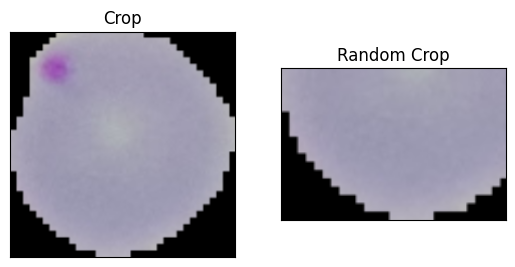

In [149]:
r_y, r_x, r_h, r_w = get_box(lmbda)
ax = plt.subplot(1,2,1)
plt.imshow(image_1)
plt.xticks(ticks=[])
plt.yticks(ticks=[])
plt.title('Crop')

ax = plt.subplot(1,2,2)
plt.imshow(tf.image.crop_to_bounding_box(image_1,r_y, r_x, r_h, r_w))
plt.xticks(ticks=[])
plt.yticks(ticks=[])
plt.title('Random Crop')
plt.show()

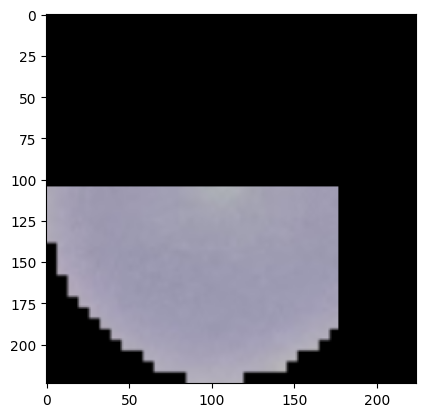

In [150]:
# copy paste operations on image

crop_img = tf.image.crop_to_bounding_box(image_1,r_y, r_x, r_h, r_w)

# pastes the cropped image on a blank image of size (im_hght,im_wdth) with the left top corner at coordinates (r_x, r_y)
pad_img = tf.image.pad_to_bounding_box(crop_img, r_y, r_x, im_hght, im_wdth)

plt.imshow(pad_img)

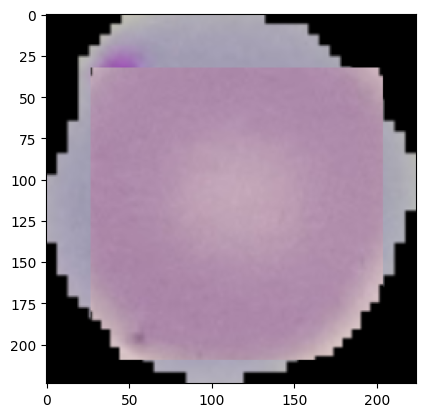

In [153]:
# now in order to place the cropped part onto another image, we can carry out these operations

r_y, r_x, r_h, r_w = get_box(lmbda)
crop_img_1 = tf.image.crop_to_bounding_box(image_1, r_y, r_x, r_h, r_w)
pad_img_1 = tf.image.pad_to_bounding_box(crop_img_1, r_y, r_x, im_hght, im_wdth)

crop_img_2 = tf.image.crop_to_bounding_box(image_2, r_y, r_x, r_h, r_w)
pad_img_2 = tf.image.pad_to_bounding_box(crop_img_2, r_y, r_x, im_hght, im_wdth)

image = image_1 - pad_img_1 + pad_img_2

plt.imshow(image)

2025-08-19 01:27:26.186136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-08-19 01:27:26.193359: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-08-19 01:27:26.194413: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-08-19 01:27:26.195022: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-08-19 01:27:26.200587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-08-19 01:27:26.201538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

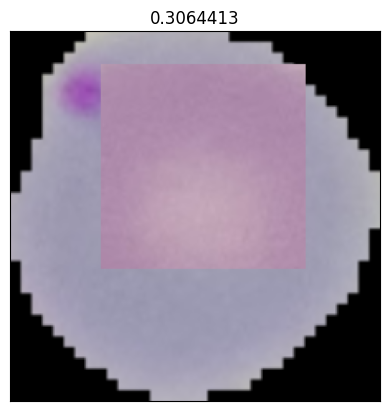

In [182]:
def CutMix(train1,train2):
    (image_1, label_1) , (image_2,label_2) = train1 , train2

    lmbda = tfp.distributions.Beta(0.2,0.2)
    lmbda = lmbda.sample(1)[0].numpy()
    
    r_y, r_x, r_h, r_w = get_box(lmbda)
    
    crop_img_1 = tf.image.crop_to_bounding_box(image_1, r_y, r_x, r_h, r_w)
    pad_img_1 = tf.image.pad_to_bounding_box(crop_img_1, r_y, r_x, im_hght, im_wdth)
    
    crop_img_2 = tf.image.crop_to_bounding_box(image_2, r_y, r_x, r_h, r_w)
    pad_img_2 = tf.image.pad_to_bounding_box(crop_img_2, r_y, r_x, im_hght, im_wdth)
    
    image = image_1 - pad_img_1 + pad_img_2

    # Due to clipping of the box and other adjustments, we need to update the lamda value respectively, so that porportion is updated
    # lamda = 1 - ((area of random crop) / (area of whole image))
    lmbda = 1 - tf.cast((r_w * r_h)/(im_wdth * im_hght),tf.float32)
    label = lmbda*tf.cast(label_1,tf.float32) + ((1-lmbda)*tf.cast(label_2,tf.float32))

    return image,label

cutmix_img, cutmix_lbl = CutMix((image_1,label_1),(image_2,label_2))
plt.imshow(cutmix_img)
plt.xticks(ticks=[])
plt.yticks(ticks=[])
plt.title(str(cutmix_lbl.numpy()))
plt.show()

## Albumentaion 

This is a library for image augmentations. This has many features that are helpful for Computer Vision Algorithms.

In [183]:
import albumentations as A

In [5]:
# creating a data augmentation pipeline

augment = A.Compose([
    A.HueSaturationValue(p=0.5), # p = probability of samples getting this function applied
    A.RandomBrightnessContrast(brightness_limit=(-0.2,0.3),contrast_limit=(-0.2,0.4),p=0.5),
    A.Flip(p=0.5),
    
    A.Affine(
        scale=(0.8, 1.2),      # Zoom in/out by 80-120%
        rotate=(-15, 15),      # Rotate by -15 to +15 degrees
        shear=(-10, 10),          # Shear by -10 to +10 degrees
        p=0.5,
        cval=0.0                  # Fill the newly created pixels by value 0
    ),
    
    A.OneOf([
        A.OpticalDistortion(distort_limit=(-0.3,0.3),interpolation=cv2.INTER_NEAREST,p=0.5),
        A.GridDistortion(interpolation=cv2.INTER_NEAREST, p=0.5),
    ],p=0.25),
    
    A.OneOf([
        A.GaussNoise(var_limit=(30,100),p=0.5),
        A.ISONoise(intensity=(0.3,0.8),p=0.5),
    ],p=0.75),
    
    A.GaussianBlur(p=0.5),
    A.Resize(224,224)
])


In [6]:
images = next(iter(train_set.take(1)))
image_1 = images[0][0]
image_2 = images[0][35]

2025-08-21 16:27:27.041217: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


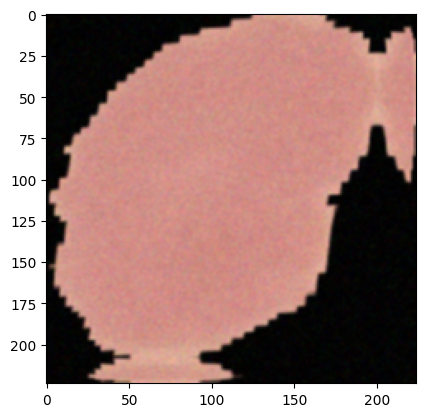

In [7]:
aug = augment(image=tf.cast(image_1*255.0,dtype=tf.uint8).numpy())["image"]
plt.imshow(aug)

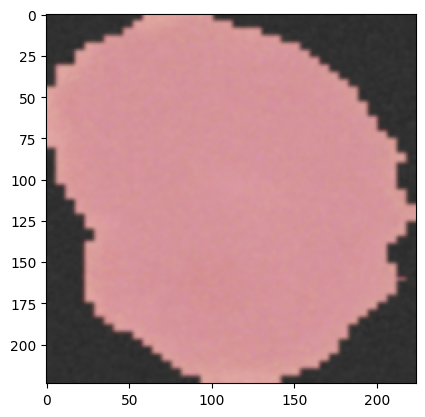

In [8]:
aug = augment(image=tf.cast(image_1*255.0,dtype=tf.uint8).numpy())["image"]
plt.imshow(aug)

In [9]:
def Apply_Augmentation(img):
    agmntd_img = augment(image = img)['image']
    return tf.cast(agmntd_img/255.0,dtype=tf.float32)

def process_data(image,label):
    aug_img = tf.numpy_function(func = Apply_Augmentation , inp = [tf.cast(image*255.0,dtype=tf.uint8)] , Tout=tf.float32)
    aug_img.set_shape([224,224,3])  # tf.numpy_function erases shape info
    return (image,aug_img), label   # just for visualization purpose, returning along with the original image


In [10]:
# albumentation needs to be applied on unbatched data, it doesnt accept 4d data (batch, height, width, channel)
sample_data = train_set.take(1)
sample_data = sample_data.unbatch().take(8).cache()

augmented_sample_data = sample_data.map(process_data)

2025-08-21 16:27:58.626759: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


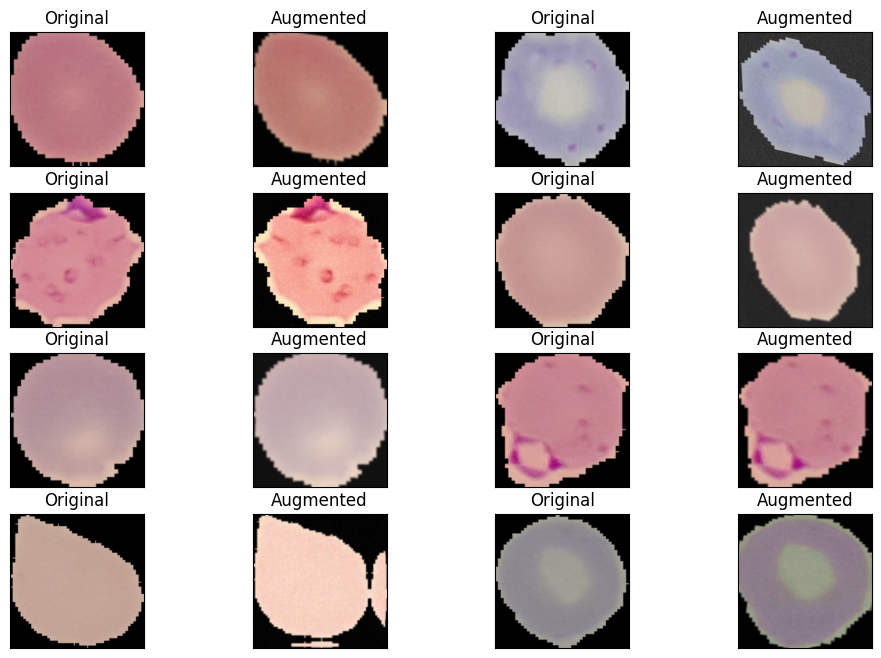

In [11]:
plt.figure(figsize=(12,8))
for j, ((org,aug),lbl) in zip(range(0,16,2), augmented_sample_data):
    ax = plt.subplot(4,4,j+1)
    plt.imshow(org)
    plt.title('Original')
    plt.xticks(ticks=[])
    plt.yticks(ticks=[])
            
    ax = plt.subplot(4,4,j+2)
    plt.imshow(aug)
    plt.title('Augmented')
    plt.xticks(ticks=[])
    plt.yticks(ticks=[])

In [12]:
# in order to apply for dataset, we need to make use of 2 functions
def Apply_Augmentation(img):
    agmntd_img = augment(image = img)['image']
    return tf.cast(agmntd_img/255.0,dtype=tf.float32)

def process_data(sample):  # as data[0] is a dictionary and not a tuple
    image = sample['image']
    label = sample['label']
    aug_img = tf.numpy_function(func = Apply_Augmentation , inp = [tf.cast(image,dtype=tf.uint8)] , Tout=tf.float32)
    aug_img.set_shape([224,224,3])  # tf.numpy_function erases shape info
    return aug_img, label           # just returning the augmented image and its label

# applying to raw unbatched data, and then batching them
# .cache() after augmentation - augmented samples cached once, same augmentations reused every epoch (bad if you want random augments).
#          before augmentation - raw data cached once, augmentations happen every epoch (good for training).
test_dataset = (
    data[0]
    .cache()
    .map(process_data, num_parallel_calls=tf.data.AUTOTUNE)
    .shuffle(1000, reshuffle_each_iteration=True)
    .batch(64)
    .prefetch(tf.data.AUTOTUNE)
)

2025-08-21 16:28:23.724553: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


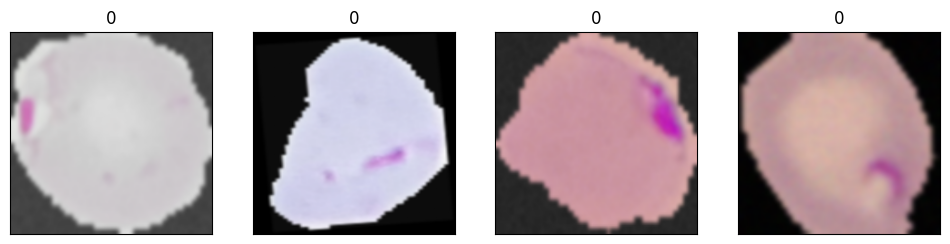

In [13]:
img, lbl = next(iter(test_dataset.take(1)))
plt.figure(figsize=(12,4))
for i in range(0,4):
    ax = plt.subplot(1,4,i+1)
    plt.imshow(img[i])
    plt.title(str(lbl[i].numpy()))
    plt.xticks(ticks=[])
    plt.yticks(ticks=[])

In [14]:
del test_dataset

## Custom Training Loop

Using Model 2 (.compile not required)

In [7]:
@tf.function # converts python function into static TensorFlow graph for efficient computing
             # dynamic variables like total_loss,.. cannot be included inside Graph
def compute_gradient(model, x_batch, y_true, lr):
    
    with tf.GradientTape() as tape:
        y_pred = model(x_batch, training=True)
        y_pred = tf.clip_by_value(tf.squeeze(y_pred), 0.001, 1.0 - 0.001)
        y_true = tf.squeeze(tf.cast(y_true, dtype=tf.float32))
        y_true = 1 - y_true
        loss = -tf.reduce_mean((y_true * tf.math.log(y_pred)) + ((1-y_true) * tf.math.log(1-y_pred)))
    partial_derivatives = tape.gradient(loss, model.trainable_weights)
    for i, weight in enumerate(model.trainable_weights):
        weight.assign_sub(lr * partial_derivatives[i])

    y_pred = tf.round(y_pred)
    correct_pred = tf.reduce_sum(tf.cast(tf.equal(y_pred,y_true),dtype=tf.float32)) #.numpy()
    return loss, correct_pred

In [8]:
def train(model, epochs, train_data, cv_data, lr):
    for epoch in range(epochs):
        total_loss = 0
        total_correct = 0
        total_samples = 0
        batch = 1
        print(f'Epoch {epoch+1} : ')
        for x_batch, y_true in train_data:

            loss, correct_pred = compute_gradient(model, x_batch, y_true, lr)

            total_loss += loss
            total_correct += correct_pred
            total_samples += y_true.shape[0]
            batch += 1
            
        avg_train_loss = total_loss/batch
        train_accuracy = total_correct/total_samples
        print(f'Training loss : {avg_train_loss}\tTraining accuracy : {train_accuracy}')

        total_loss_cv = 0
        total_correct_cv = 0
        total_samples_cv = 0
        batch_cv = 1
        for x_batch_cv, y_true_cv in cv_data:
            y_pred_cv = model(x_batch_cv, training=False)
            y_pred_cv = tf.clip_by_value(tf.squeeze(y_pred_cv), 0.001, 1.0 - 0.001)
            y_true_cv = tf.squeeze(tf.cast(y_true_cv, dtype=tf.float32))
            y_true_cv = 1 - y_true_cv
            loss_cv = -tf.reduce_mean((y_true_cv * tf.math.log(y_pred_cv)) + ((1-y_true_cv) * tf.math.log(1-y_pred_cv)))
            y_pred_cv = tf.round(y_pred_cv)
            correct_pred_cv = tf.reduce_sum(tf.cast(tf.equal(y_pred_cv,y_true_cv),dtype=tf.float32))

            total_loss_cv += loss_cv
            total_correct_cv += correct_pred_cv
            total_samples_cv += y_true_cv.shape[0]
            batch_cv += 1
            
        avg_cv_loss = total_loss_cv/batch_cv
        cv_accuracy = total_correct_cv/total_samples_cv
        print(f'Validation loss : {avg_cv_loss}\tValidation accuracy : {cv_accuracy}')
        

In [11]:
train(model,10,test_set,cv_set,0.01)

Epoch 1 : 


2025-08-23 02:58:56.725603: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training loss : 0.5127736926078796	Training accuracy : 0.7651185393333435


2025-08-23 02:58:57.124089: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation loss : 0.535041332244873	Validation accuracy : 0.7177067995071411
Epoch 2 : 


2025-08-23 02:58:58.817242: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training loss : 0.5112683773040771	Training accuracy : 0.779148519039154


2025-08-23 02:58:59.206529: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation loss : 0.495220810174942	Validation accuracy : 0.7779390215873718
Epoch 3 : 


2025-08-23 02:59:00.936206: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training loss : 0.5014557838439941	Training accuracy : 0.7793903946876526


2025-08-23 02:59:01.320010: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation loss : 0.4689200520515442	Validation accuracy : 0.8033381700515747
Epoch 4 : 


2025-08-23 02:59:03.031759: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training loss : 0.5001153945922852	Training accuracy : 0.785437822341919


2025-08-23 02:59:03.417350: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation loss : 0.45060011744499207	Validation accuracy : 0.8091436624526978
Epoch 5 : 


2025-08-23 02:59:05.096431: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training loss : 0.48970383405685425	Training accuracy : 0.7951136827468872


2025-08-23 02:59:05.472439: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation loss : 0.41960152983665466	Validation accuracy : 0.8512336611747742
Epoch 6 : 


2025-08-23 02:59:07.202457: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training loss : 0.4856007397174835	Training accuracy : 0.8023706078529358


2025-08-23 02:59:07.582532: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation loss : 0.39881566166877747	Validation accuracy : 0.8584905862808228
Epoch 7 : 


2025-08-23 02:59:09.318669: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training loss : 0.47351986169815063	Training accuracy : 0.8105950355529785


2025-08-23 02:59:09.678608: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation loss : 0.37736502289772034	Validation accuracy : 0.8715530037879944
Epoch 8 : 


2025-08-23 02:59:11.443131: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training loss : 0.45357179641723633	Training accuracy : 0.8207547068595886


2025-08-23 02:59:11.821921: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation loss : 0.3460565507411957	Validation accuracy : 0.8969520926475525
Epoch 9 : 


2025-08-23 02:59:13.527095: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training loss : 0.44399160146713257	Training accuracy : 0.826802134513855


2025-08-23 02:59:13.899205: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation loss : 0.33484381437301636	Validation accuracy : 0.8853410482406616
Epoch 10 : 


2025-08-23 02:59:15.602421: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training loss : 0.4431735873222351	Training accuracy : 0.8311562538146973
Validation loss : 0.3253609836101532	Validation accuracy : 0.8947750329971313


2025-08-23 02:59:15.985738: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Accuracy : 0.84375


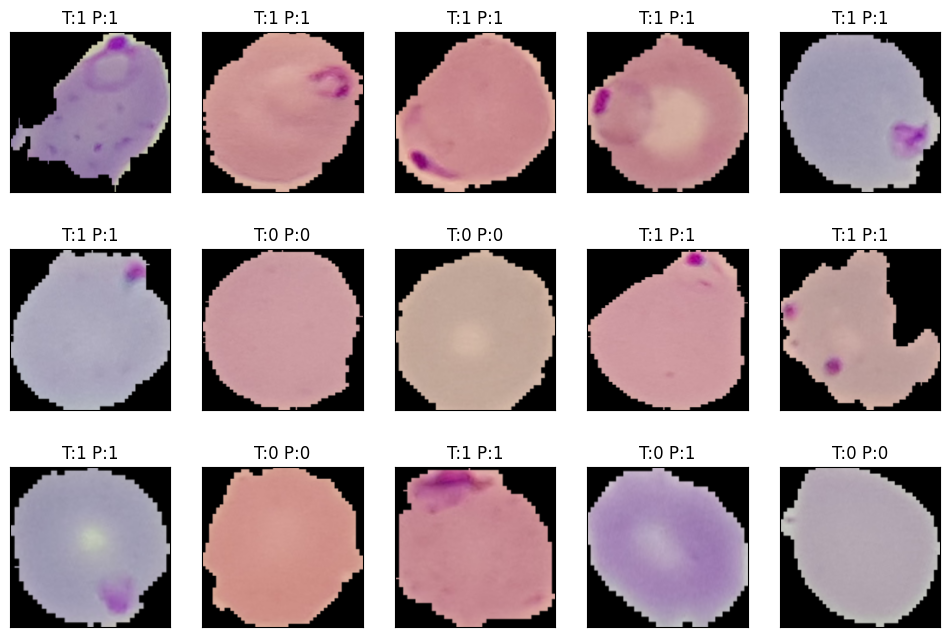

2025-08-23 02:59:50.530940: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [13]:
for x,y in cv_set.take(1):
    y_ = model(x, training=False)
    y_ = tf.round(tf.squeeze(y_))
    y = tf.cast((1-y),tf.float32)
    correct = tf.reduce_sum(tf.cast(tf.equal(y,y_),tf.float32))
    acc = correct/y.shape[0]
    print(f'Accuracy : {acc}')
    ax = plt.figure(figsize=(12,8))
    for i in range(35,35+15):
        plt.subplot(3,5,i-34)
        plt.imshow(x[i])
        plt.title('T:'+str(int(y[i].numpy()))+' P:'+str(int(y_[i].numpy())))
        plt.yticks(ticks=[])
        plt.xticks(ticks=[])    
    plt.show()

## TensorBoard along with Custom Callback

TensorBoard provides us with the dashboard of processes, metrics pertaining to training.

In [6]:
import os

In [7]:
os.makedirs('TensorBoard_Logs')

In [8]:
# continuing after defining Model 2
model.compile(loss=BinaryCrossentropy(), optimizer=Adam(learning_rate=0.01), 
              metrics=[ BinaryAccuracy(), Precision()])

In [9]:
stamp = datetime.datetime.now().strftime('%d%m%y - %h%m%s')
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='TensorBoard_Logs/'+stamp)

In [10]:
model.fit(cv_set, epochs=5, validation_data=test_set, callbacks=[tensorboard_callback])

Epoch 1/5


2025-08-27 15:39:58.045190: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - binary_accuracy: 0.5914 - loss: 1.0612 - precision: 0.5941 - val_binary_accuracy: 0.4954 - val_loss: 2.9964 - val_precision: 0.4954
Epoch 2/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - binary_accuracy: 0.6422 - loss: 0.7901 - precision: 0.6343 - val_binary_accuracy: 0.5046 - val_loss: 1.3863 - val_precision: 0.0000e+00
Epoch 3/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - binary_accuracy: 0.6466 - loss: 0.7211 - precision: 0.6434 - val_binary_accuracy: 0.5798 - val_loss: 0.7206 - val_precision: 0.6836
Epoch 4/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - binary_accuracy: 0.6553 - loss: 0.6945 - precision: 0.6576 - val_binary_accuracy: 0.5914 - val_loss: 0.7271 - val_precision: 0.5512
Epoch 5/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - binary_accuracy: 0.6814 - loss: 0.6628 - precision: 0.6763 - val_binary_accuracy: 0.5832 - val_loss: 0.7113 - val_precision: 0.5451


In [11]:
%load_ext tensorboard

In [12]:
tensorboard --logdir='TensorBoard_Logs/270825 - Aug081756289396/'

In [17]:
log_dir = 'TensorBoard_Logs/' 
stamp = datetime.datetime.now().strftime('%d%m%y - %h%m%s')
print(log_dir+stamp)

TensorBoard_Logs/250825 - Aug081756142908


In [13]:
# as there is no provision to include Learning rate directly from ReduceLROnPlateau, defining a custom callback function
class ReduceLR_Logger(tf.keras.callbacks.Callback):
    def __init__(self, logger):
        self.logger = logger
        
    def on_epoch_begin(self,epoch,logs=None):
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        with self.logger.as_default():
            tf.summary.scalar(name='Learning Rate',data=lr,step=epoch)
    

In [14]:
from sklearn.metrics import confusion_matrix

class ConfusionMatrix_Logger(tf.keras.callbacks.Callback):
    def __init__(self, logger, val_data, y_true, verbose=0):
        self.logger = logger
        self.val_data = val_data
        self.y_true = y_true
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs=None):
        y_pred = tf.squeeze(self.model.predict(self.val_data, verbose=0))
    
        y_pred = tf.cast((y_pred > 0.5),tf.int32)
            
        conf_mtrx = confusion_matrix(self.y_true, y_pred)

        plt.figure(figsize=(6,4))
        sns.heatmap(conf_mtrx,annot=True,fmt='g')
        plt.title('Confusion Matrix')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')

        buffer = io.BytesIO()
        plt.savefig(buffer, format='png')

        plt.close()

        image = tf.expand_dims(tf.image.decode_png(buffer.getvalue(), channels=3),0)

        with self.logger.as_default():
            tf.summary.image(name=f'Confusion Matrix/epoch_{epoch:03d}', data=image, step=epoch)
            tn, fp, fn, tp = conf_mtrx.ravel()
            tf.summary.scalar('Confusion_Matrix/TN', tn, step=epoch)
            tf.summary.scalar('Confusion_Matrix/FP', fp, step=epoch)
            tf.summary.scalar('Confusion_Matrix/FN', fn, step=epoch)
            tf.summary.scalar('Confusion_Matrix/TP', tp, step=epoch)
        

In [15]:
lr_plateau = ReduceLROnPlateau(monitor='val_BinAcc',patience=2, 
                               factor=0.5,
                               verbose=1,
                               min_lr=0.001)

In [16]:
metrics = [TruePositives(name='tp'), TrueNegatives(name='tn'), FalsePositives(name='fp'), FalseNegatives(name='fn'),
          BinaryAccuracy(name='BinAcc'), Precision(name='precision'), Recall(name='recall')]

model.compile(loss=BinaryCrossentropy(), optimizer=Adam(learning_rate=0.01), metrics=metrics)

In [17]:
stamp = datetime.datetime.now().strftime('%d%m%y - %h%m%s')
logger = tf.summary.create_file_writer(logdir='TensorBoard_Logs/'+stamp)
lr_logger = ReduceLR_Logger(logger)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='TensorBoard_Logs/'+stamp)

In [18]:
graph_writer = tf.summary.create_file_writer('TensorBoard_Logs/'+stamp)

@tf.function
def trace_model(x):
    return model(x)

with graph_writer.as_default():
    # The 'name' parameter is important for TensorBoard to pick it up
    tf.summary.graph(trace_model.get_concrete_function(tf.TensorSpec(shape=[None, 224, 224, 3], dtype=tf.float32)).graph)

In [19]:
y_true = []
for x,y in test_set:
    y_true.extend(y.numpy())
y_true = np.array(y_true)
cm_logger = ConfusionMatrix_Logger(logger, test_set, y_true, verbose=0)

2025-08-27 15:41:30.161698: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [20]:
model.fit(cv_set, epochs=8, validation_data=test_set, callbacks=[lr_plateau,lr_logger,cm_logger,tensorboard_callback])

Epoch 1/8
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 188ms/step - BinAcc: 0.6379 - fn: 235.0000 - fp: 264.0000 - loss: 0.7050 - precision: 0.6297 - recall: 0.6564 - tn: 430.0000 - tp: 449.0000 - val_BinAcc: 0.5099 - val_fn: 11.0000 - val_fp: 2015.0000 - val_loss: 0.9152 - val_precision: 0.5027 - val_recall: 0.9946 - val_tn: 71.0000 - val_tp: 2037.0000 - learning_rate: 0.0100
Epoch 2/8
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - BinAcc: 0.6996 - fn: 190.0000 - fp: 224.0000 - loss: 0.6580 - precision: 0.6880 - recall: 0.7222 - tn: 470.0000 - tp: 494.0000 - val_BinAcc: 0.5017 - val_fn: 9.0000 - val_fp: 2051.0000 - val_loss: 1.0355 - val_precision: 0.4985 - val_recall: 0.9956 - val_tn: 35.0000 - val_tp: 2039.0000 - learning_rate: 0.0100
Epoch 3/8
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - BinAcc: 0.7073 - fn: 91.0455 - fp: 120.5909 - loss: 0.6398 - precision: 0.6679 - recall: 0.7577 - tn: 257.8182 - tp: 265.1818
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
22/22 ━━━━━━━━━━━━

In [16]:
%load_ext tensorboard

In [21]:
tensorboard --logdir='TensorBoard_Logs/270825 - Aug081756289486/'

## Hyperparameter Tuning : TensorBoard

To understand the way model behaves for different parameters, and then deciding on the best combination that leads to best results.

Simplifying the training process to reduce resource consumption.

In [26]:
len(data[1])

1378

In [3]:
sample_train, sample_cv = tf.keras.utils.split_dataset(data[1].map(image_resize),left_size=0.5)

2025-08-29 00:32:56.467219: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [4]:
sample_train = sample_train.batch(64).cache().prefetch(tf.data.AUTOTUNE)
sample_cv = sample_cv.batch(64).cache().prefetch(tf.data.AUTOTUNE)

In [36]:
from tensorboard.plugins.hparams import api as hp

In [5]:
def model_tune(hparams):
    
    model = tf.keras.Sequential([
        Conv2D(filters=hparams[filters], kernel_size=(3,3), strides=(1,1), padding='valid',
               activation='relu',kernel_regularizer=L2(hparams[reg_rate])),
        BatchNormalization(), 
        SpatialDropout2D(hparams[drop_rate]), 
        MaxPool2D(pool_size=(2,2),strides=(2,2)),
        Flatten(),
        Dense(units=hparams[neurons],activation='relu'),
        BatchNormalization(),
        Dropout(hparams[drop_rate]), 
        Dense(units=1,activation='sigmoid')   
    ])
    
    model.compile(optimizer=Adam(hparams[learn_rate]),loss=BinaryCrossentropy(),metrics=[BinaryAccuracy()])
    
    model.fit(sample_train, validation_data=sample_cv, epochs=1)
    
    return model.evaluate(sample_cv)
    

In [6]:
filters = hp.HParam('filters', hp.Discrete([8,16]))
drop_rate = hp.HParam('drop_rate', hp.Discrete([0.1,0.2]))
neurons = hp.HParam('neurons', hp.Discrete([64,128]))
reg_rate = hp.HParam('reg_rate', hp.Discrete([0.01,0.005]))
learn_rate = hp.HParam('learn_rate', hp.Discrete([0.01,0.001]))

In [40]:
os.makedirs('TensorBoard_Logs/HyperParameter_Tuning')

In [7]:
run = 1
for filtr in filters.domain.values:
    for drp_rate in drop_rate.domain.values:
        for neuron in neurons.domain.values:
            for regularize in reg_rate.domain.values:
                for learn in learn_rate.domain.values:

                    hparams = {
                        filters : filtr,
                        drop_rate : drp_rate,
                        neurons : neuron,
                        reg_rate : regularize,
                        learn_rate : learn
                    }

                    print(f'Run {run} - Hparams : Filters={filtr}  DropOut_Rate={drp_rate}  Neurons={neuron}  Regularization_Rate={regularize}  Learning_Rate={learn}')


                    file_writer = tf.summary.create_file_writer('TensorBoard_Logs/HyperParameter_Tuning/'+str(run))

                    with file_writer.as_default():
                        hp.hparams(hparams)
                        loss, acc = model_tune(hparams)
                        tf.summary.scalar(name='loss', data=loss, step=0)
                        tf.summary.scalar(name='accuracy', data=acc, step=0)

                    run += 1
                    

Run 1 - Hparams : Filters=8  DropOut_Rate=0.1  Neurons=64  Regularization_Rate=0.005  Learning_Rate=0.001


2025-08-29 00:33:46.670351: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - binary_accuracy: 0.5864 - loss: 1.4900 - val_binary_accuracy: 0.5254 - val_loss: 2.9693
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - binary_accuracy: 0.5254 - loss: 2.9693
Run 2 - Hparams : Filters=8  DropOut_Rate=0.1  Neurons=64  Regularization_Rate=0.005  Learning_Rate=0.01
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - binary_accuracy: 0.4949 - loss: 1.4606 - val_binary_accuracy: 0.5254 - val_loss: 7.9903
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - binary_accuracy: 0.5254 - loss: 7.9903
Run 3 - Hparams : Filters=8  DropOut_Rate=0.1  Neurons=64  Regularization_Rate=0.01  Learning_Rate=0.001
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - binary_accuracy: 0.5864 - loss: 1.7201 - val_binary_accuracy: 0.5254 - val_loss: 8.9039
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - binary_accuracy: 0.5254 - loss: 8.9039
Run 4 - Hparams : Filters=8  DropOut_Rate=0.1  Neurons=64  Regularization_Rate=0.01  Learning_Rate=0.01
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - binary_ac

In [8]:
%load_ext tensorboard

In [9]:
tensorboard --logdir='TensorBoard_Logs/HyperParameter_Tuning/'

## WandB

In [2]:
!wandb login

wandb: Currently logged in as: r-sumanth (r-sumanth-personal) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [2]:
os.environ["WANDB_NOTEBOOK_NAME"] = "Malaria_Detection.ipynb" 

In [9]:
os.makedirs('WandB_Checkpoint')

In [10]:
# saving randomly initialized weights of Model 2
model.save_weights('SavedWeights/Malaria_Randomly_Initialized_v2.weights.h5')

In [11]:
# Defining and Compiling Model 2
model.compile(loss=BinaryCrossentropy(), optimizer=Adam(learning_rate=0.001), metrics=[BinaryAccuracy(),Precision(),Recall()])

In [12]:
from wandb.integration.keras import WandbMetricsLogger,WandbModelCheckpoint

with wandb.init(project='Malaria-Detection-v1',name='Simple-CNN',save_code=True) as run:
    early_stop = EarlyStopping(monitor='val_binary_accuracy', patience=3, restore_best_weights=True, verbose=1)
    model.fit(train_set,epochs=5,validation_data=cv_set,
              callbacks=[WandbMetricsLogger(),WandbModelCheckpoint('WandB_Checkpoint/Malaria-Detection-v1_0.keras'),early_stop])

wandb: Currently logged in as: r-sumanth (r-sumanth-personal) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch 1/5


2025-09-15 17:07:17.584016: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


345/345 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - binary_accuracy: 0.8031 - loss: 0.7409 - precision: 0.7729 - recall: 0.8597 - val_binary_accuracy: 0.4964 - val_loss: 2.1306 - val_precision: 0.4964 - val_recall: 1.0000
Epoch 2/5
345/345 ━━━━━━━━━━━━━━━━━━━━ 58s 169ms/step - binary_accuracy: 0.9041 - loss: 0.4585 - precision: 0.8777 - recall: 0.9396 - val_binary_accuracy: 0.8360 - val_loss: 0.5380 - val_precision: 0.7573 - val_recall: 0.9854
Epoch 3/5
345/345 ━━━━━━━━━━━━━━━━━━━━ 62s 179ms/step - binary_accuracy: 0.9195 - loss: 0.4411 - precision: 0.8973 - recall: 0.9478 - val_binary_accuracy: 0.9478 - val_loss: 0.3851 - val_precision: 0.9359 - val_recall: 0.9605
Epoch 4/5
345/345 ━━━━━━━━━━━━━━━━━━━━ 65s 189ms/step - binary_accuracy: 0.9247 - loss: 0.4519 - precision: 0.9061 - recall: 0.9479 - val_binary_accuracy: 0.9376 - val_loss: 0.4635 - val_precision: 0.9614 - val_recall: 0.9108
Epoch 5/5
345/345 ━━━━━━━━━━━━━━━━━━━━ 63s 182ms/step - binary_accuracy: 0.9261 - loss: 0.4637 - precision:

In [11]:
# to include image classification outputs of validation data for visualization
from wandb.integration.keras import WandbEvalCallback

In [13]:
class WnBImageViz(WandbEvalCallback):
    def __init__(self, val_data):
        super().__init__(data_table_columns=["idx", "image", "label"], 
                         pred_table_columns=["epoch", "idx", "image", "true", "pred"])
        for val_x, val_y in val_data: 
            self.x = val_x
            self.y = val_y

    def add_ground_truth(self, logs=None):
        for idx,(image,label) in enumerate(zip(self.x,self.y)):
            self.data_table.add_data(idx, wandb.Image(image), int(label.numpy()))
        wandb.log({"val_Actual": self.data_table})

    def add_model_predictions(self, epoch, logs=None):
        preds = self.model.predict(self.x, verbose=0)
        preds = tf.squeeze(preds)
        for idx in range(len(preds)):
            self.pred_table.add_data(epoch, idx, wandb.Image(self.x[idx]), self.y[idx], int(tf.round(preds[idx]).numpy()))
        wandb.log({f"val_Predictions_epoch_{epoch}": self.pred_table})
            

In [14]:
viz_data = data[1].map(image_resize)
viz_data = viz_data.batch(64).take(1).cache().prefetch(tf.data.AUTOTUNE)

In [15]:
early_stop = EarlyStopping(monitor='val_binary_accuracy', patience=3, restore_best_weights=True, verbose=1)
model.load_weights('SavedWeights/Malaria_Randomly_Initialized_v2.weights.h5')

with wandb.init(project='Malaria-Detection-v1', name='CNN+Viz') as run:
    early_stop = EarlyStopping(monitor='val_binary_accuracy', patience=3, restore_best_weights=True, verbose=1)
    model.fit(train_set,epochs=5,validation_data=cv_set,
              callbacks=[WandbMetricsLogger(),WandbModelCheckpoint('WandB_Checkpoint/Malaria-Detection-v1_1.keras'),
                         WnBImageViz(val_data=viz_data),early_stop])
    

/opt/anaconda3/envs/tf_env/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 38 variables whereas the saved optimizer has 0 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2025-09-15 17:13:54.624083: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
wandb:   65 of 65 files downloaded.  


Epoch 1/5
345/345 ━━━━━━━━━━━━━━━━━━━━ 68s 197ms/step - binary_accuracy: 0.7064 - loss: 0.8336 - precision: 0.6851 - recall: 0.7663 - val_binary_accuracy: 0.5000 - val_loss: 1.0579 - val_precision: 0.4982 - val_recall: 1.0000
Epoch 2/5
345/345 ━━━━━━━━━━━━━━━━━━━━ 66s 190ms/step - binary_accuracy: 0.8614 - loss: 0.6183 - precision: 0.8191 - recall: 0.9284 - val_binary_accuracy: 0.8643 - val_loss: 0.5497 - val_precision: 0.7941 - val_recall: 0.9810
Epoch 3/5
345/345 ━━━━━━━━━━━━━━━━━━━━ 68s 195ms/step - binary_accuracy: 0.9062 - loss: 0.5077 - precision: 0.8762 - recall: 0.9466 - val_binary_accuracy: 0.9427 - val_loss: 0.4632 - val_precision: 0.9315 - val_recall: 0.9547
Epoch 4/5
345/345 ━━━━━━━━━━━━━━━━━━━━ 71s 207ms/step - binary_accuracy: 0.9136 - loss: 0.5001 - precision: 0.8870 - recall: 0.9483 - val_binary_accuracy: 0.9448 - val_loss: 0.5080 - val_precision: 0.9510 - val_recall: 0.9371
Epoch 5/5
345/345 ━━━━━━━━━━━━━━━━━━━━ 71s 205ms/step - binary_accuracy: 0.9141 - loss: 0.5315 -

In [16]:
# Adding custom charts like Confusion Matrix 
# creating custom callback (of keras class) to log the chart

from tensorflow.keras.callbacks import Callback

class ConfMtrxLogger(Callback):
    def __init__(self, val_data, y_true):
        self.val_data = val_data
        self.y_true = y_true
        
    def on_epoch_end(self, epoch, logs=None):
        y_pred = tf.squeeze(self.model.predict(self.val_data,verbose=0))
        y_pred = tf.cast((y_pred>0.5), tf.int32).numpy()

        wandb.log({'Confusion Matrix' : wandb.plot.confusion_matrix(y_true=self.y_true, preds=y_pred,
                                                                   class_names=['Parasitized', 'Uninfected'])})
    

In [17]:
y_true = []
for x,y in cv_set:
    y_true.extend(y.numpy())
y_true = np.array(y_true)

early_stop = EarlyStopping(monitor='val_binary_accuracy', patience=3, restore_best_weights=True, verbose=1)
model.load_weights('SavedWeights/Malaria_Randomly_Initialized_v2.weights.h5')

with wandb.init(project='Malaria-Detection-v1', name='CNN+Conf-Mtrx') as run:
    model.fit(train_set,epochs=5,validation_data=cv_set,
              callbacks=[WandbMetricsLogger(),WandbModelCheckpoint('WandB_Checkpoint/Malaria-Detection-v1_2.keras'),
                         early_stop,ConfMtrxLogger(cv_set,y_true)])
    

2025-09-15 17:20:13.582190: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/opt/anaconda3/envs/tf_env/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 38 variables whereas the saved optimizer has 0 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/5
345/345 ━━━━━━━━━━━━━━━━━━━━ 50s 145ms/step - binary_accuracy: 0.7647 - loss: 0.7325 - precision: 0.7351 - recall: 0.8293 - val_binary_accuracy: 0.4964 - val_loss: 1.6644 - val_precision: 0.4964 - val_recall: 1.0000
Epoch 2/5
345/345 ━━━━━━━━━━━━━━━━━━━━ 52s 151ms/step - binary_accuracy: 0.9100 - loss: 0.3919 - precision: 0.8786 - recall: 0.9519 - val_binary_accuracy: 0.9165 - val_loss: 0.3375 - val_precision: 0.8680 - val_recall: 0.9810
Epoch 3/5
345/345 ━━━━━━━━━━━━━━━━━━━━ 49s 141ms/step - binary_accuracy: 0.9251 - loss: 0.3422 - precision: 0.9015 - recall: 0.9547 - val_binary_accuracy: 0.9456 - val_loss: 0.3223 - val_precision: 0.9381 - val_recall: 0.9532
Epoch 4/5
345/345 ━━━━━━━━━━━━━━━━━━━━ 51s 148ms/step - binary_accuracy: 0.9285 - loss: 0.3420 - precision: 0.9092 - recall: 0.9524 - val_binary_accuracy: 0.9383 - val_loss: 0.3149 - val_precision: 0.9064 - val_recall: 0.9766
Epoch 5/5
345/345 ━━━━━━━━━━━━━━━━━━━━ 53s 154ms/step - binary_accuracy: 0.9296 - loss: 0.3562 -

## HyperParameter Tuning : WandB

In [10]:
sweep_config = {
    'method' : 'random', # / 'grid' / 'bayes'
    'metric' : {
        'name' : 'epoch/val_binary_accuracy',
        'goal' : 'maximize'
    },
    'parameters' : {
        'n_filters_1' : {
            'values' : [4,6,8]
        },
        'n_filters_2' : {
            'values' : [12,15,18]
        },
        'regularize_rate' : {
            'distribution' : 'uniform',
            'min' : 0.001,
            'max' : 0.01
        },
        'dropout_rate' : {
            'distribution': 'normal',
            'mu': 0.2,
            'sigma': 0.05  # sample values centered around 0.2, with spread 0.05.


        },
        'n_units_1' : {
            'values' : [108,128,144]
        },
        'n_units_2' : {
            'values' : [48,64,90]
        },
        'learn_rate' : {
            'distribution' : 'uniform',
            'min' : 0.001,
            'max' : 0.1
        }
    }
}
        

In [8]:
def tune_model(config=None):
    with wandb.init(config=config):
        config = wandb.config
        model = tf.keras.Sequential([
            InputLayer(shape=(224,224,3)),
            Conv2D(filters=config.n_filters_1, kernel_size=(4,4), strides=(2,2), padding='valid',activation='relu',
                   kernel_regularizer=L2(config.regularize_rate)),
            BatchNormalization(),
            
            MaxPool2D(pool_size=(2,2), strides=(2,2)),
            
            Conv2D(filters=config.n_filters_2, kernel_size=(3,3), strides=(1,1), padding='valid',activation='relu'),
            BatchNormalization(), 
            SpatialDropout2D(rate=config.dropout_rate), 
            
            MaxPool2D(pool_size=(2,2),strides=(2,2)),
            
            Flatten(),
            
            Dense(units=config.n_units_1,activation='relu'),
            BatchNormalization(),
            Dropout(rate=config.dropout_rate), 
            
            Dense(units=config.n_units_2,activation='relu', kernel_regularizer=L2(config.regularize_rate)),
            BatchNormalization(),
        
            
            Dense(units=1,activation='sigmoid')   
        ])
        
        model.compile(optimizer=Adam(config.learn_rate), loss=BinaryCrossentropy(), metrics=[BinaryAccuracy(),Precision(),Recall()])

        model.fit(test_set, epochs=5, validation_data=cv_set, callbacks=[WandbMetricsLogger()])
        

In [11]:
sweep_id = wandb.sweep(sweep_config, project="Malaria-Detection-HPT")
wandb.agent(sweep_id, function=tune_model, count=5)

Create sweep with ID: sqrwpu0r
Sweep URL: https://wandb.ai/r-sumanth-personal/Malaria-Detection-HPT/sweeps/sqrwpu0r


wandb: Agent Starting Run: 87v3y4ka with config:
wandb: 	dropout_rate: 0.1652636849761161
wandb: 	learn_rate: 0.03845429079059806
wandb: 	n_filters_1: 6
wandb: 	n_filters_2: 18
wandb: 	n_units_1: 128
wandb: 	n_units_2: 64
wandb: 	regularize_rate: 0.009677200802293373


Epoch 1/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - binary_accuracy: 0.6084 - loss: 0.9570 - precision: 0.5973 - recall: 0.6431 - val_binary_accuracy: 0.5218 - val_loss: 0.8310 - val_precision: 0.5096 - val_recall: 0.9708
Epoch 2/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - binary_accuracy: 0.6766 - loss: 0.7064 - precision: 0.6496 - recall: 0.7539 - val_binary_accuracy: 0.6350 - val_loss: 0.7950 - val_precision: 0.5836 - val_recall: 0.9240
Epoch 3/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - binary_accuracy: 0.7762 - loss: 0.6706 - precision: 0.7298 - recall: 0.8706 - val_binary_accuracy: 0.5000 - val_loss: 1.3936 - val_precision: 0.4982 - val_recall: 1.0000
Epoch 4/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - binary_accuracy: 0.8077 - loss: 0.6509 - precision: 0.7495 - recall: 0.9189 - val_binary_accuracy: 0.5813 - val_loss: 0.9433 - val_precision: 0.5430 - val_recall: 0.9883
Epoch 5/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - binary_accuracy: 0.7970 - loss: 0.6653 - precision: 0.7427 -

wandb: Agent Starting Run: 7gqiw23o with config:
wandb: 	dropout_rate: 0.11260207887749676
wandb: 	learn_rate: 0.0025677579942794235
wandb: 	n_filters_1: 4
wandb: 	n_filters_2: 18
wandb: 	n_units_1: 144
wandb: 	n_units_2: 48
wandb: 	regularize_rate: 0.0010880295474752944


Epoch 1/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - binary_accuracy: 0.6294 - loss: 0.7430 - precision: 0.6223 - recall: 0.6411 - val_binary_accuracy: 0.5370 - val_loss: 0.7750 - val_precision: 0.5181 - val_recall: 0.9635
Epoch 2/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - binary_accuracy: 0.7080 - loss: 0.6485 - precision: 0.6910 - recall: 0.7427 - val_binary_accuracy: 0.5239 - val_loss: 0.7907 - val_precision: 0.5106 - val_recall: 0.9839
Epoch 3/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - binary_accuracy: 0.7642 - loss: 0.5629 - precision: 0.7386 - recall: 0.8110 - val_binary_accuracy: 0.4978 - val_loss: 2.6843 - val_precision: 0.4971 - val_recall: 1.0000
Epoch 4/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - binary_accuracy: 0.8573 - loss: 0.4333 - precision: 0.8217 - recall: 0.9092 - val_binary_accuracy: 0.4964 - val_loss: 4.7959 - val_precision: 0.4964 - val_recall: 1.0000
Epoch 5/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - binary_accuracy: 0.9103 - loss: 0.3402 - precision: 0.8813 -

wandb: Agent Starting Run: vyoozfxi with config:
wandb: 	dropout_rate: 0.22681363839415908
wandb: 	learn_rate: 0.07062278323352936
wandb: 	n_filters_1: 4
wandb: 	n_filters_2: 18
wandb: 	n_units_1: 108
wandb: 	n_units_2: 48
wandb: 	regularize_rate: 0.006713242014346864


Epoch 1/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - binary_accuracy: 0.5934 - loss: 0.9582 - precision: 0.5923 - recall: 0.5752 - val_binary_accuracy: 0.5036 - val_loss: 1.4461 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - binary_accuracy: 0.6219 - loss: 0.7034 - precision: 0.6202 - recall: 0.6108 - val_binary_accuracy: 0.4964 - val_loss: 3.0960 - val_precision: 0.4964 - val_recall: 1.0000
Epoch 3/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - binary_accuracy: 0.6318 - loss: 0.6934 - precision: 0.6328 - recall: 0.6118 - val_binary_accuracy: 0.5036 - val_loss: 1.4864 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - binary_accuracy: 0.6362 - loss: 0.6812 - precision: 0.6335 - recall: 0.6304 - val_binary_accuracy: 0.4964 - val_loss: 3.7199 - val_precision: 0.4964 - val_recall: 1.0000
Epoch 5/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - binary_accuracy: 0.6437 - loss: 0.6708 - pre

wandb: Agent Starting Run: 64qa901r with config:
wandb: 	dropout_rate: 0.30143918470449077
wandb: 	learn_rate: 0.02217041162574809
wandb: 	n_filters_1: 4
wandb: 	n_filters_2: 12
wandb: 	n_units_1: 144
wandb: 	n_units_2: 64
wandb: 	regularize_rate: 0.0021131035128656803


Epoch 1/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - binary_accuracy: 0.6297 - loss: 0.8388 - precision: 0.6181 - recall: 0.6606 - val_binary_accuracy: 0.6016 - val_loss: 0.7133 - val_precision: 0.5594 - val_recall: 0.9298
Epoch 2/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - binary_accuracy: 0.6872 - loss: 0.6667 - precision: 0.6695 - recall: 0.7280 - val_binary_accuracy: 0.5007 - val_loss: 1.3015 - val_precision: 0.4985 - val_recall: 1.0000
Epoch 3/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - binary_accuracy: 0.8016 - loss: 0.5455 - precision: 0.7658 - recall: 0.8638 - val_binary_accuracy: 0.4964 - val_loss: 1.0435 - val_precision: 0.4964 - val_recall: 1.0000
Epoch 4/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - binary_accuracy: 0.8636 - loss: 0.4843 - precision: 0.8193 - recall: 0.9297 - val_binary_accuracy: 0.7583 - val_loss: 0.7409 - val_precision: 0.6838 - val_recall: 0.9547
Epoch 5/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - binary_accuracy: 0.8774 - loss: 0.4964 - precision: 0.8396 -

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: en3ycl0v with config:
wandb: 	dropout_rate: 0.15934954150726738
wandb: 	learn_rate: 0.0436276128804943
wandb: 	n_filters_1: 6
wandb: 	n_filters_2: 12
wandb: 	n_units_1: 128
wandb: 	n_units_2: 48
wandb: 	regularize_rate: 0.0026553774529064133


Epoch 1/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - binary_accuracy: 0.6060 - loss: 0.9419 - precision: 0.6028 - recall: 0.5996 - val_binary_accuracy: 0.4985 - val_loss: 2.1577 - val_precision: 0.4975 - val_recall: 1.0000
Epoch 2/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - binary_accuracy: 0.6376 - loss: 0.6868 - precision: 0.6308 - recall: 0.6475 - val_binary_accuracy: 0.5305 - val_loss: 0.7104 - val_precision: 0.5144 - val_recall: 0.9649
Epoch 3/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - binary_accuracy: 0.7061 - loss: 0.6558 - precision: 0.6842 - recall: 0.7554 - val_binary_accuracy: 0.4964 - val_loss: 3.2570 - val_precision: 0.4964 - val_recall: 1.0000
Epoch 4/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - binary_accuracy: 0.8191 - loss: 0.5156 - precision: 0.7987 - recall: 0.8486 - val_binary_accuracy: 0.5000 - val_loss: 1.0220 - val_precision: 0.4982 - val_recall: 1.0000
Epoch 5/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - binary_accuracy: 0.8348 - loss: 0.5129 - precision: 0.7961 -

## Dataset Versoning : WandB

To track the changes to the data through the process of preprocessing, augmentation,.. we store the dataset which can be reproduced in subsequent runs, which can be accessed by different people from different machines (from WandB cloud)

Datasets cannot be directly stored into WandB cloud, we need to store that locally first and then upload.

In [3]:
# just to have reduced dataset size for efficient resource utilization
data = tfds.load('malaria',split=['train[:98%]','train[98%:]'],shuffle_files=True)

2025-09-25 18:42:19.586707: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2025-09-25 18:42:19.586751: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-09-25 18:42:19.586754: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2025-09-25 18:42:19.586768: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-09-25 18:42:19.586785: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
def load_data_into_WandB(data, version, typ, status):
    with wandb.init(project='Malaria-Artifact-Versioning',name=f'v{version}-{typ}') as run:
        try:
            artifact = wandb.Artifact(name=f'{typ}', type=f'{status}_data', 
                                      description = 'Malaria dataset from Tensorflow Datasets')
            
            local_path = os.path.join('Artifacts-WandB-Malaria',status,typ)
            data.save(local_path)
            
            artifact.add_dir(local_path)
            run.log_artifact(artifact)
            
        finally:
            if os.path.exists(local_path):
                shutil.rmtree(os.path.join('Artifacts-WandB-Malaria',status))
                                

In [5]:
load_data_into_WandB(data=data[1], version='0', typ='raw', status='unprocessed')

wandb: Currently logged in as: r-sumanth (r-sumanth-personal) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: Adding directory to artifact (Artifacts-WandB-Malaria/unprocessed/raw)... Done. 0.1s


In [6]:
def image_resize(data):
    return tf.image.resize(data['image'],size=(224,224))/255 , data['label']

In [7]:
def load_preprocess_data(artifact_path, artifact_type, version, typ, status):
    with wandb.init(project='Malaria-Artifact-Versioning',name=f'v{version}-{typ}') as run:
        try:
            artifact = run.use_artifact(artifact_path, artifact_type)
            artifact_dir = artifact.download()

            raw_data = tf.data.Dataset.load(artifact_dir)
            raw_data = raw_data.map(image_resize)
            train_set, cv_set = tf.keras.utils.split_dataset(raw_data,left_size=0.7,seed=53)
            train_set = train_set.batch(64)
            cv_set = cv_set.batch(64)

            train_artfct = wandb.Artifact(name=f'{typ}-train', type=f'{status}_data', 
                                      description = 'Malaria dataset preprocessed to resized and rescaled samples and split as train data')
            train_path = os.path.join('Artifacts-WandB-Malaria',status,'train')
            train_set.save(train_path)
            train_artfct.add_dir(train_path)
            run.log_artifact(train_artfct)

            cv_artfct = wandb.Artifact(name=f'{typ}-cv', type=f'{status}_data', 
                                      description = 'Malaria dataset preprocessed to resized and rescaled samples and split as cross validation data')
            cv_path = os.path.join('Artifacts-WandB-Malaria',status,'cv')
            cv_set.save(cv_path)
            cv_artfct.add_dir(cv_path)
            run.log_artifact(cv_artfct)

        finally:
            if os.path.exists(artifact_dir) and os.path.exists(train_path) and os.path.exists(cv_path):
                shutil.rmtree(artifact_dir)
                shutil.rmtree(os.path.join('Artifacts-WandB-Malaria',status))

In [8]:
# these are taken from the Usage API tab of the previously logged data

artifact_path = 'r-sumanth-personal/Malaria-Artifact-Versioning/raw:v0' 
artifact_type = 'unprocessed_data'

load_preprocess_data(artifact_path, artifact_type, '2', 'resized', 'preprocessed')


wandb:   3 of 3 files downloaded.  
2025-09-25 18:43:38.607814: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
wandb: Adding directory to artifact (Artifacts-WandB-Malaria/preprocessed/train)... Done. 0.6s
wandb: Adding directory to artifact (Artifacts-WandB-Malaria/preprocessed/cv)... Done. 0.3s


## Model Versioning : WandB

By manually logging the models, we can create a graph flow in where we can understand the dataflow of the whole process

In [9]:
def log_model(train, model_type, version, status, config, typ=None,
              model=None, train_path=None, cv_path=None, model_path=None, artifact_type=None):
    with wandb.init(project='Malaria-Artifact-Versioning', name=f'v{version}-{status}') as run:
        if train:
            train_artfct = run.use_artifact(train_path, artifact_type)
            train_dir = train_artfct.download()
            train_set = tf.data.Dataset.load(train_dir)
            train_set = train_set.cache().prefetch(tf.data.AUTOTUNE)

            cv_artfct = run.use_artifact(cv_path, artifact_type)
            cv_dir = cv_artfct.download()
            cv_set = tf.data.Dataset.load(cv_dir)
            cv_set = cv_set.cache().prefetch(tf.data.AUTOTUNE)

            model_artfct = run.use_artifact(model_path, model_type)
            model_dir = model_artfct.download()
            model = tf.keras.models.load_model(os.path.join(model_dir,os.listdir(model_dir)[0]))

            model.compile(optimizer=Adam(0.01), loss=BinaryCrossentropy(), metrics=[BinaryAccuracy(), Precision(), Recall()])
            model.fit(train_set, validation_data=cv_set, epochs=3, callbacks=[WandbMetricsLogger()])
            os.makedirs(os.path.join('Artifacts-WandB-Malaria',status))
            trained_model_dir = os.path.join('Artifacts-WandB-Malaria',status)
            model.save(os.path.join(trained_model_dir,'Malaria_Detection_Trained.keras'))

            model_artfct = wandb.Artifact(name=f'Trained-Model', type=f'{status}_model',
                                          description=f'Model trained on {train_path}', metadata=config)
            model_artfct.add_dir(trained_model_dir)
            wandb.log_artifact(model_artfct)
            
            shutil.rmtree(os.path.join('Artifacts-WandB-Malaria',status))
            shutil.rmtree(train_dir)
            shutil.rmtree(cv_dir)
            shutil.rmtree(model_dir)

        else :
            model.compile(optimizer=Adam(0.01), loss=BinaryCrossentropy(), metrics=[BinaryAccuracy(), Precision(), Recall()])
            os.makedirs(os.path.join('Artifacts-WandB-Malaria',status))
            model_dir = os.path.join('Artifacts-WandB-Malaria',status,'Malaria_Detection_Untrained.keras')
            model.save(model_dir)

            model_artfct = wandb.Artifact(name=f'Initial-Model', type=f'{status}_model',
                                          description=f'Model saved after defining it', metadata=config)
            model_artfct.add_dir(os.path.join('Artifacts-WandB-Malaria',status))
            wandb.log_artifact(model_artfct)
            
            shutil.rmtree(os.path.join('Artifacts-WandB-Malaria',status))

            

In [10]:
config = {
        'n_filters_1' : 6,
        'n_filters_2' : 16,
        'regularize_rate' : 0.005,
        'dropout_rate' : 0.2,
        'n_units_1' : 128,
        'n_units_2' : 64,
        'learn_rate' : 0.01
    }

LeNet_Model = tf.keras.Sequential([
            InputLayer(shape=(224,224,3)),
            Conv2D(filters=config['n_filters_1'], kernel_size=(4,4), strides=(2,2), padding='valid',activation='relu',
                   kernel_regularizer=L2(config['regularize_rate'])),
            BatchNormalization(),
            
            MaxPool2D(pool_size=(2,2), strides=(2,2)),
            
            Conv2D(filters=config['n_filters_2'], kernel_size=(3,3), strides=(1,1), padding='valid',activation='relu'),
            BatchNormalization(), 
            SpatialDropout2D(rate=config['dropout_rate']), 
            
            MaxPool2D(pool_size=(2,2),strides=(2,2)),
            
            Flatten(),
            
            Dense(units=config['n_units_1'],activation='relu'),
            BatchNormalization(),
            Dropout(rate=config['dropout_rate']), 
            
            Dense(units=config['n_units_2'],activation='relu', kernel_regularizer=L2(config['regularize_rate'])),
            BatchNormalization(),
        
            
            Dense(units=1,activation='sigmoid')   
        ])

In [11]:
log_model(train=False, model_type='Initial', version='3', status='pre-trained', config=config, model=LeNet_Model)

wandb: Adding directory to artifact (Artifacts-WandB-Malaria/pre-trained)... Done. 0.0s


In [12]:
train_path = 'r-sumanth-personal/Malaria-Artifact-Versioning/resized-train:v0'
cv_path = 'r-sumanth-personal/Malaria-Artifact-Versioning/resized-cv:v0'
artifact_type = 'preprocessed_data'
model_path = 'r-sumanth-personal/Malaria-Artifact-Versioning/Initial-Model:v0'
model_type = 'pre-trained_model'

log_model(train=True, version='4', status='trained', config=config, train_path=train_path, cv_path=cv_path, artifact_type=artifact_type,
          model_path=model_path, model_type=model_type)

wandb: Downloading large artifact 'resized-train:v0', 221.65MB. 3 files...
wandb:   3 of 3 files downloaded.  
Done. 00:00:01.0 (212.6MB/s)
wandb: Downloading large artifact 'resized-cv:v0', 94.75MB. 3 files...
wandb:   3 of 3 files downloaded.  
Done. 00:00:01.0 (95.0MB/s)
wandb:   1 of 1 files downloaded.  


Epoch 1/3


/opt/anaconda3/envs/tf_env/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 38 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
2025-09-25 18:44:58.814557: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - binary_accuracy: 0.5181 - loss: 1.5321 - precision_1: 0.5380 - recall_1: 0.4950 - val_binary_accuracy: 0.4788 - val_loss: 10.5192 - val_precision_1: 0.4788 - val_recall_1: 1.0000
Epoch 2/3
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - binary_accuracy: 0.6166 - loss: 1.0303 - precision_1: 0.6215 - recall_1: 0.6650 - val_binary_accuracy: 0.4788 - val_loss: 4.4764 - val_precision_1: 0.4788 - val_recall_1: 1.0000
Epoch 3/3
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - binary_accuracy: 0.6477 - loss: 0.9198 - precision_1: 0.6524 - recall_1: 0.6850 - val_binary_accuracy: 0.4788 - val_loss: 7.7931 - val_precision_1: 0.4788 - val_recall_1: 1.0000


wandb: Adding directory to artifact (Artifacts-WandB-Malaria/trained)... Done. 0.1s
